In [1]:
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport
import chardet
import glob
import os
import shutil
import seaborn as sns
import matplotlib.pyplot as plt
import unicodedata
import sys
import cfunits

# import custom modules
sys.path.append('../scripts')
import funcs

/opt/homebrew/anaconda3/envs/leaf/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---
---
# Table of contents
* [1. Load source data](#load-data)
    * [1.1. Preview headers](#preview-headers)  
* [2. Prepare data headers](#prep-headers)
    * [2.1. Preview headers, descriptions, and units](#view-headers)
    * [2.2. Clean headers, descriptions, and units](#clean-headers)
        * [2.2.1. Units (multi-header index 2)](#units)
        * [2.2.2. Descriptions (multi-header index 1)](#descriptions)
        * [2.2.3. Variables (multi-header index 0)](#variables)
        * [2.2.4. Data values](#data-vals)
* [3. Standardize data headers](#standardizing-steps)
    * [3.1. Copy of filename_headers to filename_headers_lookup](#copy)
    * [3.2. Assign lookup table header names](#assign)
    * [3.3. Use ESS-Dive leaf-gas-exchange standards to create lookup table](#multiheader-standards)
    * [3.4. Load the lookup table](#complete-lookup)
    * [3.5. Use the lookup table to standardize headers](#standardize)
* [4. Data quality control](#qc)
    * [4.1. Strings](#strings)
    * [4.2. Measurememt device](#device)
    * [4.3. Season](#season)
    * [4.4. Plant height](#height)
    * [4.5. Datetimes](#datetimes)
    * [4.6. Species names](#species)
    * [4.7. Create species lookup table](#species-lookup)
    * [4.8. Fill in species lookup table](#fill-species-lookup)
        * [4.8.1. Format headers](#species-lookup-headers)
        * [4.8.2. Merge lookup table with data](#merge)
        * [4.8.3. Drop extra columns](#drop)
* [5. Data unit conversion](#unit-conversion)
    * [5.1. Visualize and confirm unit conversions](#confirm-conversion)
    * [5.2. Drop out-of-range (oor) values](#oor)

---
---
## 1. Load the data <a class="anchor" id="load-data"></a>
NOTE: If certain fancy characters aren't used in a file, an encoder will pick it up as us/ascii even if I've explicitly encoded it as utf-8-sig, and that's fine. UTF-8-SIG just ensures that the .csv is read properly in Excel on a Mac AND a windows computer.

In [2]:
filename = 'kumarathunge_2019'
# ensure readable encoding of summary data (01) and raw curve data (02)
data_path = f'../data/input/{filename}/ACi-TGlob_V1.0.csv'
utf8_data_path = funcs.convert_to_utf8sig(data_path)

# ensure readable encoding of metadata files (01, 02)
metadata_path = f'../data/input/{filename}/ACi-TGlob_V1.0_metadata.csv'
utf8_metadata_path = funcs.convert_to_utf8sig(metadata_path)

Encoding utf-8 was detected for ../data/input/kumarathunge_2019/ACi-TGlob_V1.0.csv.
Converted ../data/input/kumarathunge_2019/ACi-TGlob_V1.0.csv to utf-8-sig and saved as ../data/input/kumarathunge_2019/ACi-TGlob_V1.0_utf8sig.csv
Encoding utf-8 was detected for ../data/input/kumarathunge_2019/ACi-TGlob_V1.0_metadata.csv.
Converted ../data/input/kumarathunge_2019/ACi-TGlob_V1.0_metadata.csv to utf-8-sig and saved as ../data/input/kumarathunge_2019/ACi-TGlob_V1.0_metadata_utf8sig.csv


In [3]:
# read the data
data = pd.read_csv(utf8_data_path, low_memory=False, na_values=[-9999])
metadata = pd.read_csv(utf8_metadata_path, low_memory=False)

In [4]:
# clean up data column names
data.columns = (data.columns.str.strip()
                .str.lower()
                .str.replace(' ', '_'))

In [5]:
# clean up metadata column names
metadata.rename(columns={'Variable':'variable',
                         'Description':'description',
                         'Units':'unit'}, inplace=True)
metadata = metadata[['variable', 'description', 'unit']]
metadata = metadata[metadata['variable'] != 'species'] # header doesnt even exist in data
metadata['variable'] = (metadata['variable'].str.strip()
                        .str.lower()
                        .str.replace(' ', '_'))

In [6]:
# there's an error to fix in the metadata
# lifespan should be leafspan
diff = list(set(data.columns.to_list()) ^ set(metadata['variable'].to_list()))
diff

['lifespan', 'leafspan']

In [7]:
metadata[metadata['variable'] == 'lifespan']

,variable,description,unit
4,lifespan,Evergreen or Deciduous,NaN


In [8]:
metadata['variable'] = metadata['variable'].replace('lifespan', 'leafspan')

---
### 1.1. Preview the data and metadata headers <a class="anchor" id="preview-headers"></a>
If there are no metadata provided, you must create a metadata .csv based on the headers in the data

In [9]:
data.columns

Index(['dataset', 'data_type', 'data_contributor', 'location', 'leafspan',
       'tregion', 'type', 'pft', 'growth_condition', 'species',
       'seed_source_latitude', 'seed_source_longitude', 'season', 'date',
       'temp_treatment', 'co2_treatment', 'chamber', 'water_treatment',
       'leaf_age', 'replicate', 'curve_id', 'curve_number', 'photo', 'cond',
       'ci', 'vpdl', 'tair', 'tleaf', 'tblk', 'co2r', 'co2s', 'pari', 'mat',
       'maxt', 'mgdd0', 'reference'],
      dtype='object')

In [10]:
np.array(metadata['variable'])

array(['dataset', 'data_type', 'data_contributor', 'location', 'leafspan',
       'tregion', 'type', 'pft', 'growth_condition', 'species',
       'seed_source_latitude', 'seed_source_longitude', 'season', 'date',
       'temp_treatment', 'co2_treatment', 'chamber', 'water_treatment',
       'leaf_age', 'replicate', 'curve_id', 'curve_number', 'photo',
       'cond', 'ci', 'vpdl', 'tair', 'tleaf', 'tblk', 'co2r', 'co2s',
       'pari', 'mat', 'maxt', 'mgdd0', 'reference'], dtype=object)

---
---
## 2. Prepare data headers <a class="anchor" id="prep-headers"></a>
Add variable/description/units to as a 3-row multi-header

In [11]:
# merge metadata with data column names
columns_df = pd.DataFrame({'variable': data.columns})
matched_metadata = columns_df.merge(metadata, on='variable', how='left')

# check for unmatched variables
unmatched = matched_metadata[matched_metadata['description'].isnull()]
if not unmatched.empty:
    print("Warning: Some columns in the data file do not match the metadata:")
    print(unmatched)

In [12]:
# drop unmatched variables
matched_metadata = matched_metadata.dropna(subset=['variable'])
data = data[matched_metadata['variable'].tolist()]

# create the description and unit rows
description_row = matched_metadata['description'].tolist()
unit_row = matched_metadata['unit'].tolist()
data_with_metadata = pd.concat(
    [pd.DataFrame([description_row, unit_row], columns=data.columns), data],
    ignore_index=True)

# Set the multi-index
data_with_metadata.columns = pd.MultiIndex.from_arrays(
    [data.columns, description_row, unit_row],
    names=['variable', 'description', 'unit'])
data_with_metadata = data_with_metadata.iloc[2:]

# replace data dataframe with the one with metadata
data = data_with_metadata.iloc[2:].copy()

---
### 2.1. Preview headers, descriptions, and units <a class="anchor" id="view-headers"></a>

In [13]:
data.columns.get_level_values(0)

Index(['dataset', 'data_type', 'data_contributor', 'location', 'leafspan',
       'tregion', 'type', 'pft', 'growth_condition', 'species',
       'seed_source_latitude', 'seed_source_longitude', 'season', 'date',
       'temp_treatment', 'co2_treatment', 'chamber', 'water_treatment',
       'leaf_age', 'replicate', 'curve_id', 'curve_number', 'photo', 'cond',
       'ci', 'vpdl', 'tair', 'tleaf', 'tblk', 'co2r', 'co2s', 'pari', 'mat',
       'maxt', 'mgdd0', 'reference'],
      dtype='object', name='variable')

In [14]:
data.columns.get_level_values(1)

Index(['unique name given for individual datasets', 'data grouping tag',
       'name of the individual dataset contributors',
       'site where the dataset collected', 'Evergreen or Deciduous', 'Biome',
       'Gymnosperm or angiosperm', 'plant functional type',
       'plant growth condition', 'standard species name',
       'species' seed source latitude', 'species' seed source longitude',
       'measurement season', 'data collection date',
       'experimental temperature treatments', 'experimental CO2 treatments',
       'unique chamber number for whole tree chamber experiments',
       'experimental watering treatments', 'leaf age', 'replicate id',
       'a unique curve number for individual ACi curves in a dataset',
       'a unique curve number for individual ACi curves within the dataset',
       'net photosynthetic rate', 'stomatal conductance',
       'intercellular CO2 concentration', 'Vapour pressure deficit',
       'air temperature', 'leaf temperature', 'LICOR block t

In [15]:
data.columns.get_level_values(2).unique()

Index([                                                                                                                                                                                                                                                    nan,
                                                                                                                                        'ACi-T: ACi temperature response data; An-T: temperature response of net photosynthesis at ambient CO2 concentrations',
       'ARCTIC: arctic tundra, NET-TE: temperate needle leaf evergreen trees; NET-B: boreal needle leaf evergreen trees; BDT-TE: temperate broadleaf decibuous trees; BET-TE: temperate broadleaf evergreen trees; BET-Tr: tropical broadleaf evergreen trees',
                                                                                                                                                                                                          '"ambient", "elevated", "no_te

---
### 2.2. Clean headers, descriptions, and units <a class="anchor" id="clean-headers"></a>

#### 2.2.1. Units (multi-header index 2) <a class="anchor" id="units"></a>
Some examples of correct unit formats:
* mmol m-2 s-1
* m-2 s-1
* 1 (for unitless values or categorical data)
* degree_C
* degree (for decimal degrees)

In [16]:
# clean units using local modules in funcs.py: funcs.clean_values()
values = data.columns.get_level_values(2)
cleaned_l2_values = funcs.clean_values(values)

# replace unclean units with cleaned units
data.columns = pd.MultiIndex.from_arrays([
    data.columns.get_level_values(0),
    data.columns.get_level_values(1),
    cleaned_l2_values
])

In [17]:
replacement_l2_vals = {np.nan:None,
                       'ACi-T: ACi temperature response data; An-T: temperature response of net photosynthesis at ambient CO2 concentrations':1,
                       'ARCTIC: arctic tundra, NET-TE: temperate needle leaf evergreen trees; NET-B: boreal needle leaf evergreen trees; BDT-TE: temperate broadleaf decibuous trees; BET-TE: temperate broadleaf evergreen trees; BET-Tr: tropical broadleaf evergreen trees':1,
                       '"ambient", "elevated", "no_temperature_treatments"':1,
                       '"ambient", "elevated", "no_CO2_treatments"':1,
                       '"wet", "dry"':1,
                       'years':1,
                       '°C':'degree_C'}

In [18]:
# standardize level-2 (unit) values
# Get the levels from the MultiIndex
level_0 = data.columns.get_level_values(0)
level_1 = data.columns.get_level_values(1)
level_2 = data.columns.get_level_values(2).to_series().replace(replacement_l2_vals)

# Reassign the modified levels back to all_data.columns as a new MultiIndex
data.columns = pd.MultiIndex.from_arrays([level_0, level_1, level_2])

#### 2.2.2. Descriptions (multi-header index 1) <a class="anchor" id="descriptions"></a>

In [19]:
# clean descriptions using local modules in funcs.py: funcs.clean_values()
values = data.columns.get_level_values(1)
cleaned_l1_values = funcs.clean_values(values)

# replace unclean descriptions with cleaned descriptions
data.columns = pd.MultiIndex.from_arrays([
    data.columns.get_level_values(0),
    cleaned_l1_values,
    data.columns.get_level_values(2),
])

#### 2.2.3. Variables (multi-header index 0) <a class="anchor" id="variables"></a>

In [20]:
values = data.columns.get_level_values(0)
cleaned_l0_values = funcs.clean_values(values)
data.columns = pd.MultiIndex.from_arrays([
    cleaned_l0_values,
    data.columns.get_level_values(1),
    data.columns.get_level_values(2),
])

#### 2.2.4 Data values
* Ensure proper encoding ('NFKC' Unicode)
* Convert string 1 to integer 1

In [21]:
duplicate_columns = data.columns[data.columns.duplicated()]
print("Duplicate columns:")
print(duplicate_columns)
data = data.loc[:, ~data.columns.duplicated()]

Duplicate columns:
MultiIndex([], names=['variable', 'description', 'unit'])


In [22]:
# Apply normalization to all multiheader rows
data = data.sort_index(axis=1)
data_norm = funcs.encode_dataframe_values(data)
header_df = pd.DataFrame({
    'variable': data_norm.columns.get_level_values(0),
    'description': data_norm.columns.get_level_values(1),
    'unit': data_norm.columns.get_level_values(2)
})

# Display the resulting DataFrame
header_df.head(5)

,variable,description,unit
0,chamber,unique chamber number for whole tree chamber e...,NaN
1,ci,intercellular CO2 concentration,μmol mol-1
2,co2_treatment,experimental CO2 treatments,"ambient"", ""elevated"", ""no_CO2_treatments"
3,co2r,reference CO2 concentration,μmol mol-1
4,co2s,CO2 concentration at leaf surface,μmol mol-1


In [23]:
header_df.to_csv(f'../data/temp/headers/{filename}_headers.csv', index=None, encoding='utf-8-sig')

---
---
## 3. Standardize variables, descriptions, & units with Lookup Table
</br>

---
### 3.1. First, create a copy of `../data/temp/headers/{filename}_headers.csv` at `../data/temp/headers/{filename}_headers_lookup.csv`
</br>

---
### 3.2. Name the headers `variable`, `description`, `unit`, `standard_variable`, `standard_description`, `standard_Unit`
</br>

---
### 3.3. Using ESS-Dive leaf-gas-exchange standards, assign the `standard_variable`, `standard_description`, & `standard_unit` for each variable, description, & unit
This manual process will allow us to assign standardized headers in preparation for merging into the final database; data can't be merged if they don't have identical headers
* https://github.com/ess-dive-community/essdive-leaf-gas-exchange
</br>

---
### 3.4. Load the lookup table

In [24]:
# Load and set encoding of the lookup table
lookup_table = pd.read_csv(f'../data/temp/headers/{filename}_headers_lookup.csv', encoding='utf-8-sig')
lookup_table = funcs.encode_dataframe_values(lookup_table)
lookup_table.head(3)

,variable,description,unit,standard_variable,standard_description,standard_unit
0,chamber,unique chamber number for whole tree chamber e...,NaN,record,Observation record number,1
1,ci,intercellular CO2 concentration,μmol mol-1,Ci,Intercellular CO2 concentration in air,μmol mol-1
2,co2_treatment,experimental CO2 treatments,"ambient"", ""elevated"", ""no_CO2_treatments",experimentalManipulation,Experimental treatment(s) applied to the plant,1


In [25]:
# look at duplicates and determine how to handle them
column_name = 'standard_variable'
duplicate_rows = lookup_table[lookup_table.duplicated(subset=[column_name], keep=False)]
duplicate_rows

,variable,description,unit,standard_variable,standard_description,standard_unit
0,chamber,unique chamber number for whole tree chamber e...,NaN,record,Observation record number,1
2,co2_treatment,experimental CO2 treatments,"ambient"", ""elevated"", ""no_CO2_treatments",experimentalManipulation,Experimental treatment(s) applied to the plant,1
6,curve_id,a unique curve number for individual ACi curve...,NaN,record,Observation record number,1
7,curve_number,a unique curve number for individual ACi curve...,NaN,record,Observation record number,1
30,temp_treatment,experimental temperature treatments,"ambient"", ""elevated"", ""no_temperature_treatments",experimentalManipulation,Experimental treatment(s) applied to the plant,1
35,water_treatment,experimental watering treatments,"wet"", ""dry",experimentalManipulation,Experimental treatment(s) applied to the plant,1


---
### 3.5. Standardize the header using lookup table

In [26]:
# Standardize variable/description but keep original unit
lookup_dict = lookup_table.set_index(['variable', 'description', 'unit']).to_dict('index')
standard_data = funcs.standardize_headers(data_norm, lookup_dict)

In [27]:
standard_data

standard_variable,record,Ci,experimentalManipulation,CO2r,CO2s,gsw,dataContributor,data_type,siteIdentifier,date,...,season,latitudeY,longitudeX,species,Tair,Tblock,Tleaf,plantBiome,plantType,VPDleaf
standard_description,Observation record number,Intercellular CO2 concentration in air,Experimental treatment(s) applied to the plant,CO2 concentration in wet air entering chamber,CO2 concentration in wet air inside chamber,Stomatal conductance to water vapor per leaf area,Name of the individual or organization that contributed to the data,data grouping tag,Location descriptor of where data was collected,Date of observation,...,Season when the measurement was collected,Latitude coordinate of the site,Longitude coordinate of the site,Full species name and subspecies if applicable,Air temperature inside the chamber,Temperature of cooler block used to stabilize air temperature,Leaf surface temperature,"Classification of the biome based on climate and ecological characteristics, such as arctic, boreal, temperate, or tropical","Classification of plant as either gymnosperm or angiosperm, indicating differences in reproductive structures and evolutionary lineage",Leaf to air vapor pressure deficit
unit,1,μmol mol-1,1,μmol mol-1,μmol mol-1,mmol m-2 s-1,1,1,1,1,...,1,degree,degree,1,degree_C,degree_C,degree_C,1,1,kPa
4,"chamber: None, curve_id: 1.0, curve_number: 1.0",83.800000,"co2_treatment: None, temp_treatment: 22C, wate...",NaN,91.680000,0.255000,Danielle A. Way,ACi-T,"Black Spruce, ON, Canada",NaN,...,NaN,49.11,-74.61,Picea mariana,NaN,NaN,10.140000,Boreal,Gymnosperm,0.494000
5,"chamber: None, curve_id: 1.0, curve_number: 1.0",45.100000,"co2_treatment: None, temp_treatment: 22C, wate...",NaN,47.400000,0.242000,Danielle A. Way,ACi-T,"Black Spruce, ON, Canada",NaN,...,NaN,49.11,-74.61,Picea mariana,NaN,NaN,10.140000,Boreal,Gymnosperm,0.509000
6,"chamber: None, curve_id: 1.0, curve_number: 1.0",359.000000,"co2_treatment: None, temp_treatment: 22C, wate...",NaN,381.070000,0.237000,Danielle A. Way,ACi-T,"Black Spruce, ON, Canada",NaN,...,NaN,49.11,-74.61,Picea mariana,NaN,NaN,10.220000,Boreal,Gymnosperm,0.518000
7,"chamber: None, curve_id: 1.0, curve_number: 1.0",170.000000,"co2_treatment: None, temp_treatment: 22C, wate...",NaN,184.640000,0.276000,Danielle A. Way,ACi-T,"Black Spruce, ON, Canada",NaN,...,NaN,49.11,-74.61,Picea mariana,NaN,NaN,10.150000,Boreal,Gymnosperm,0.473000
8,"chamber: None, curve_id: 1.0, curve_number: 1.0",749.000000,"co2_treatment: None, temp_treatment: 22C, wate...",NaN,776.770000,0.229000,Danielle A. Way,ACi-T,"Black Spruce, ON, Canada",NaN,...,NaN,49.11,-74.61,Picea mariana,NaN,NaN,10.250000,Boreal,Gymnosperm,0.530000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61868,"chamber: None, curve_id: None, curve_number: None",249.833333,"co2_treatment: None, temp_treatment: None, wat...",368.733333,347.116667,0.322500,Belinda E. Medlyn,An-T,"Subalpine Eucalypt, AU-NSW (A)",10/05/2002,...,autumn,-35.66,148.15,Eucalyptus delegatensis,16.213333,16.273333,16.238333,Temperate_S,Angiosperm,0.795500
61869,"chamber: None, curve_id: None, curve_number: None",254.166667,"co2_treatment: None, temp_treatment: None, wat...",369.716667,343.816667,0.431667,Belinda E. Medlyn,An-T,"Subalpine Eucalypt, AU-NSW (A)",10/05/2002,...,autumn,-35.66,148.15,Eucalyptus delegatensis,16.540000,16.615000,16.470000,Temperate_S,Angiosperm,0.792167


In [28]:
# this file was manually curated based on info from _variables csvs
column_standards = pd.read_csv('../data/supp/columns_of_interest.csv')

# Use Unicode escape codes for clarity
mu = '\u03BC'  # Greek small letter mu (μ)
micro = '\u00B5'  # Micro sign (µ)
column_standards = column_standards.replace({mu: micro}, regex=True)

# set encoding to match our data
column_standards = funcs.encode_dataframe_values(column_standards)
column_standards.drop_duplicates(inplace=True)
column_standards

,standard_variable,standard_description,standard_unit
0,siteIdentifier,Location descriptor of where data was collected,1
1,speciesCode,Code used to identify species in data tables,1
2,record,Observation record number,1
3,date,Date of observation,1
4,time,Time of observation,1
5,measurementDevice,Name of the instrument that collected data,1
6,Tleaf,Leaf surface temperature,degree_C
7,A,Net CO2 exchange per leaf area,μmol m-2 s-1
8,Ci,Intercellular CO2 concentration in air,μmol mol-1
9,CO2s,CO2 concentration in wet air inside chamber,μmol mol-1


In [29]:
# Create the set of tuples from column_standards
valid_columns = set(zip(column_standards['standard_variable'], column_standards['standard_description']))

# Extract the tuples from the first two rows of the multi-header columns in standard_data
multi_header_tuples = [
    (standard_data.columns.get_level_values(0)[i], standard_data.columns.get_level_values(1)[i])
    for i in range(len(standard_data.columns))
]

# Subselect columns in standard_data whose tuples match the valid_columns set
selected_columns = [col for col, header_tuple in zip(standard_data.columns, multi_header_tuples) if header_tuple in valid_columns]

# Create a new DataFrame with the selected columns
filtered_standard_data = standard_data[selected_columns]
filtered_standard_data.head(3)

standard_variable,record,Ci,experimentalManipulation,CO2r,CO2s,gsw,dataContributor,siteIdentifier,date,growthEnvironment,...,season,latitudeY,longitudeX,species,Tair,Tblock,Tleaf,plantBiome,plantType,VPDleaf
standard_description,Observation record number,Intercellular CO2 concentration in air,Experimental treatment(s) applied to the plant,CO2 concentration in wet air entering chamber,CO2 concentration in wet air inside chamber,Stomatal conductance to water vapor per leaf area,Name of the individual or organization that contributed to the data,Location descriptor of where data was collected,Date of observation,"Growth conditions of the plant, indicating whether it is growing under ambient (normal) or stressed conditions",...,Season when the measurement was collected,Latitude coordinate of the site,Longitude coordinate of the site,Full species name and subspecies if applicable,Air temperature inside the chamber,Temperature of cooler block used to stabilize air temperature,Leaf surface temperature,"Classification of the biome based on climate and ecological characteristics, such as arctic, boreal, temperate, or tropical","Classification of plant as either gymnosperm or angiosperm, indicating differences in reproductive structures and evolutionary lineage",Leaf to air vapor pressure deficit
unit,1,μmol mol-1,1,μmol mol-1,μmol mol-1,mmol m-2 s-1,1,1,1,1,...,1,degree,degree,1,degree_C,degree_C,degree_C,1,1,kPa
4,"chamber: None, curve_id: 1.0, curve_number: 1.0",83.8,"co2_treatment: None, temp_treatment: 22C, wate...",NaN,91.68,0.255,Danielle A. Way,"Black Spruce, ON, Canada",NaN,Glasshouse,...,NaN,49.11,-74.61,Picea mariana,NaN,NaN,10.14,Boreal,Gymnosperm,0.494
5,"chamber: None, curve_id: 1.0, curve_number: 1.0",45.1,"co2_treatment: None, temp_treatment: 22C, wate...",NaN,47.40,0.242,Danielle A. Way,"Black Spruce, ON, Canada",NaN,Glasshouse,...,NaN,49.11,-74.61,Picea mariana,NaN,NaN,10.14,Boreal,Gymnosperm,0.509
6,"chamber: None, curve_id: 1.0, curve_number: 1.0",359.0,"co2_treatment: None, temp_treatment: 22C, wate...",NaN,381.07,0.237,Danielle A. Way,"Black Spruce, ON, Canada",NaN,Glasshouse,...,NaN,49.11,-74.61,Picea mariana,NaN,NaN,10.22,Boreal,Gymnosperm,0.518


Visualizing ('record', 'Observation record number', 1)


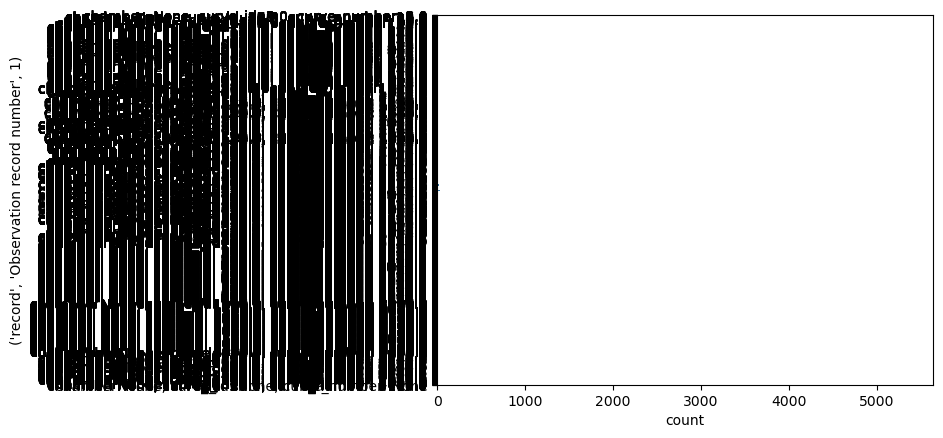

Visualizing ('Ci', 'Intercellular CO2 concentration in air', 'μmol mol-1')


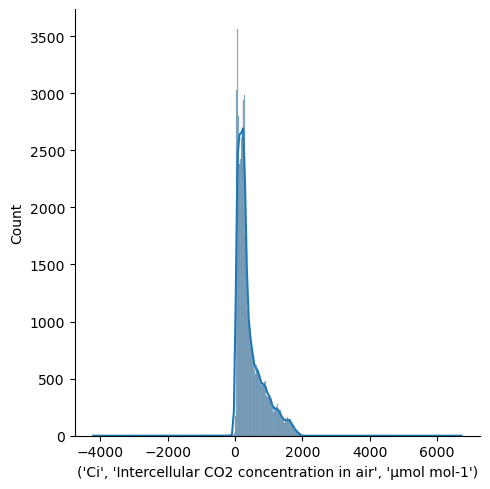

Visualizing ('experimentalManipulation', 'Experimental treatment(s) applied to the plant', 1)


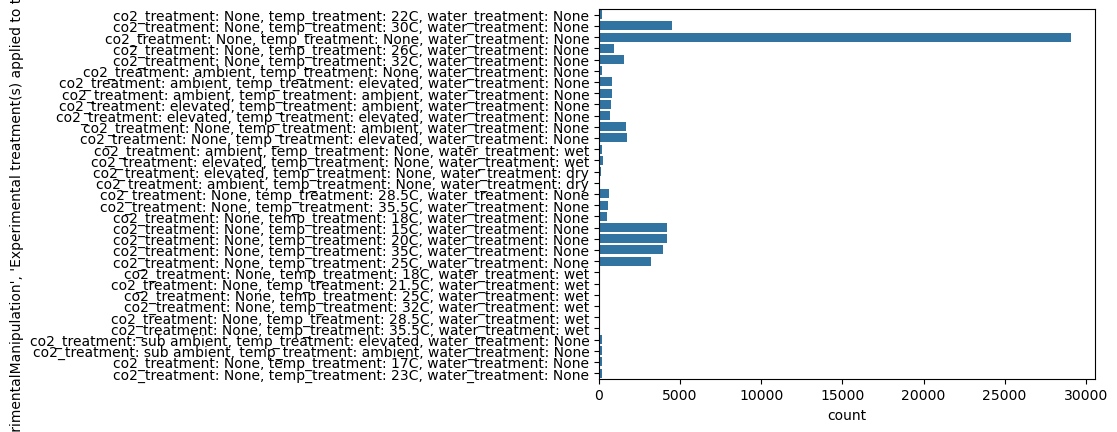

Visualizing ('CO2r', 'CO2 concentration in wet air entering chamber', 'μmol mol-1')


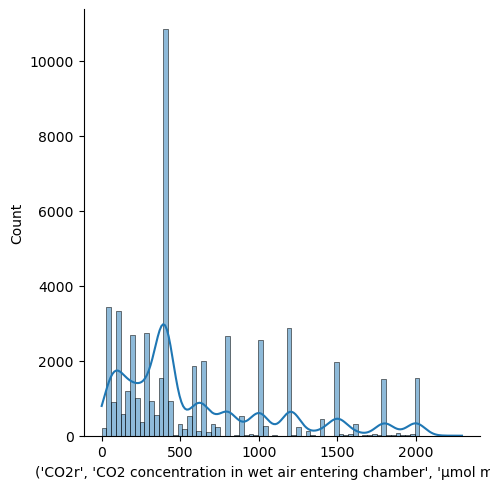

Visualizing ('CO2s', 'CO2 concentration in wet air inside chamber', 'μmol mol-1')


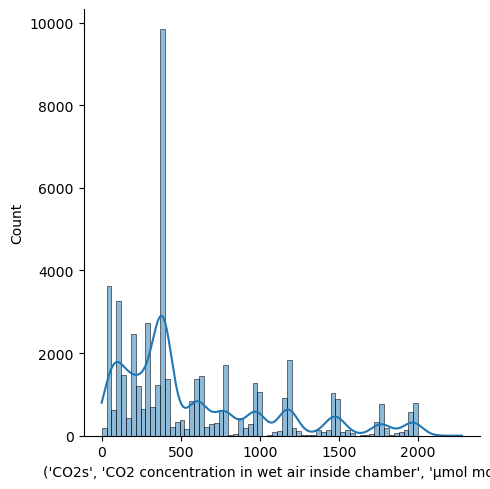

Visualizing ('gsw', 'Stomatal conductance to water vapor per leaf area', 'mmol m-2 s-1')


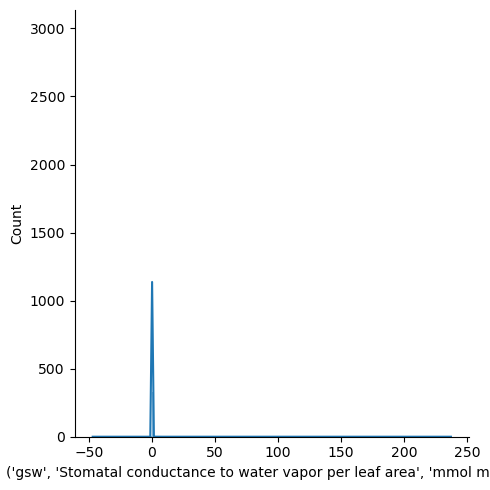

Visualizing ('dataContributor', 'Name of the individual or organization that contributed to the data', 1)


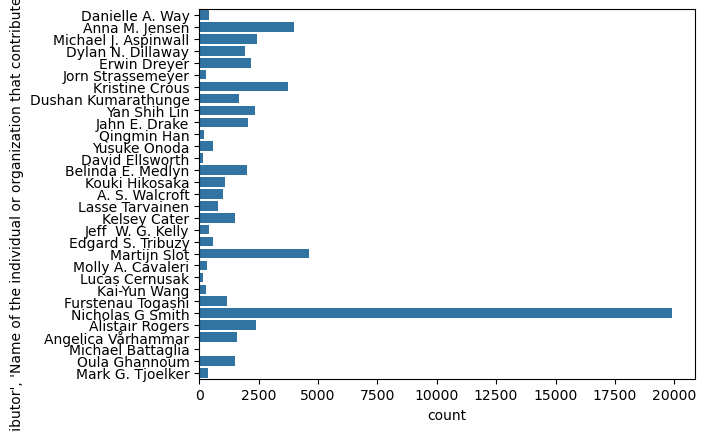

Visualizing ('siteIdentifier', 'Location descriptor of where data was collected', 1)


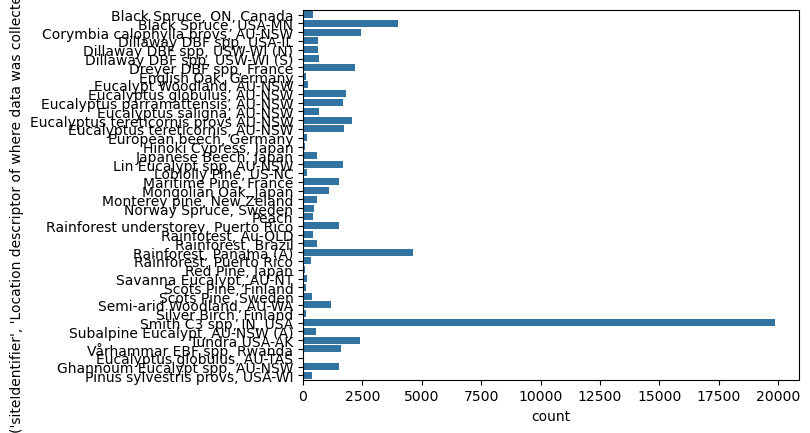

Visualizing ('date', 'Date of observation', 1)


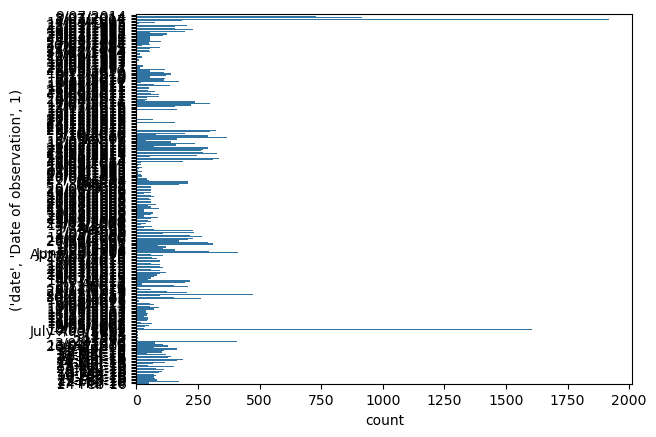

Visualizing ('growthEnvironment', 'Growth conditions of the plant, indicating whether it is growing under ambient (normal) or stressed conditions', 1)


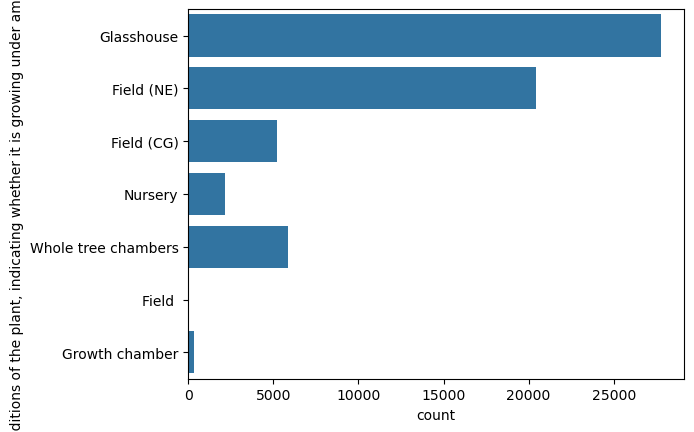

Visualizing ('plantLeaf', 'Leaf lifespan strategy of the plant, categorizing it as evergreen or deciduous based on leaf retention patterns', 1)


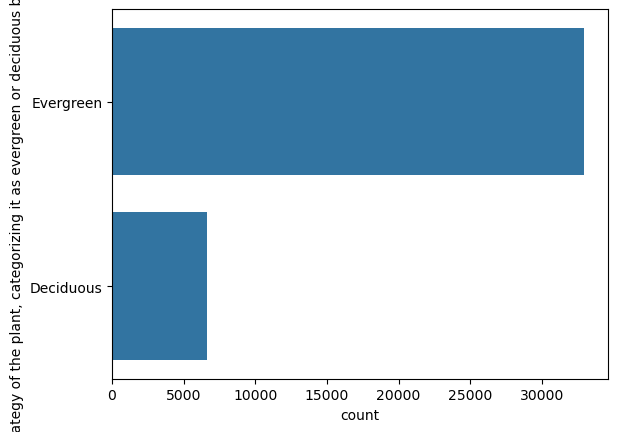

Visualizing ('plantForm', 'Life form of the plant, categorizing it as tree, shrub, grass, crop, savanna, etc., based on growth form and ecological function', 1)


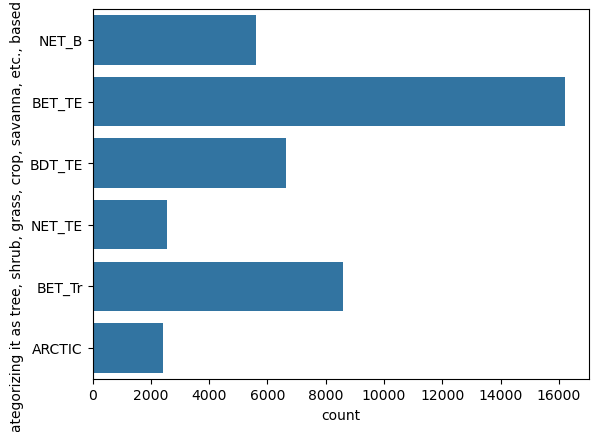

Visualizing ('A', 'Net CO2 exchange per leaf area', 'μmol m-2 s-1')


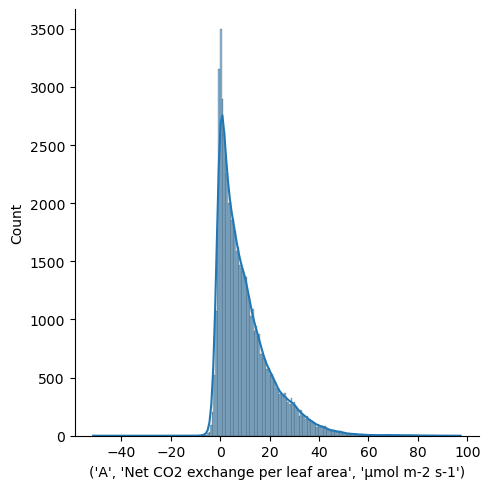

Visualizing ('replicate', 'Identification number indicating if a plant was measured more than once', 1)


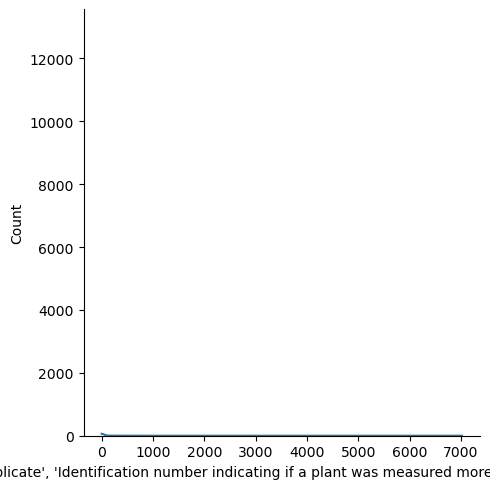

Visualizing ('season', 'Season when the measurement was collected', 1)


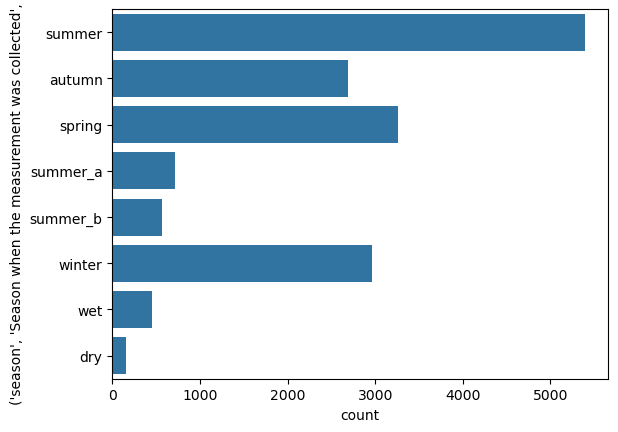

Visualizing ('latitudeY', 'Latitude coordinate of the site', 'degree')


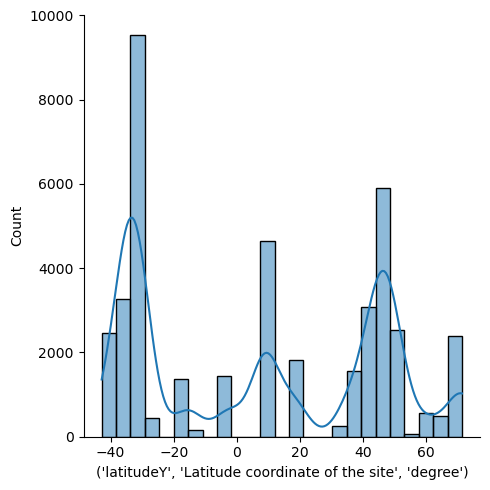

Visualizing ('longitudeX', 'Longitude coordinate of the site', 'degree')


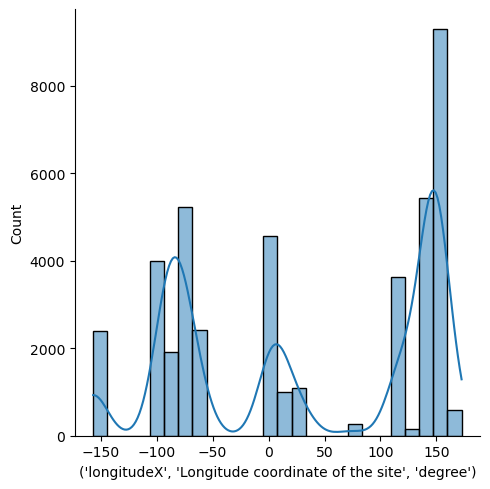

Visualizing ('species', 'Full species name and subspecies if applicable', 1)


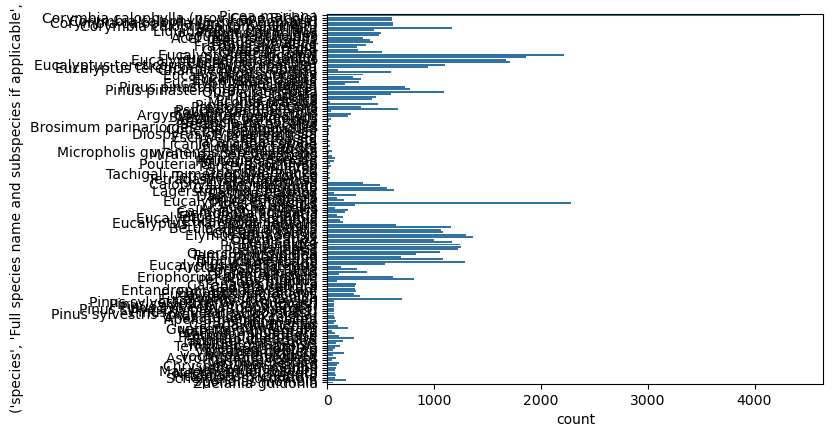

Visualizing ('Tair', 'Air temperature inside the chamber', 'degree_C')


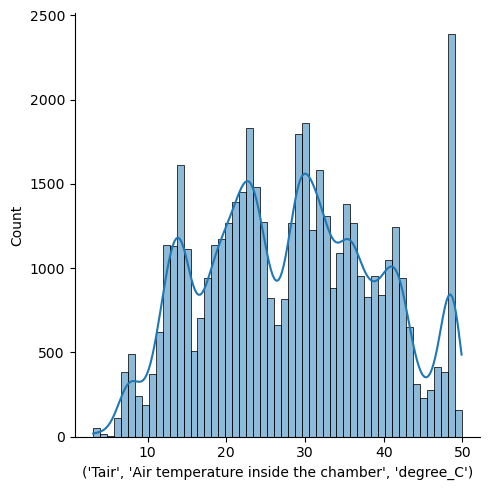

Visualizing ('Tblock', 'Temperature of cooler block used to stabilize air temperature', 'degree_C')


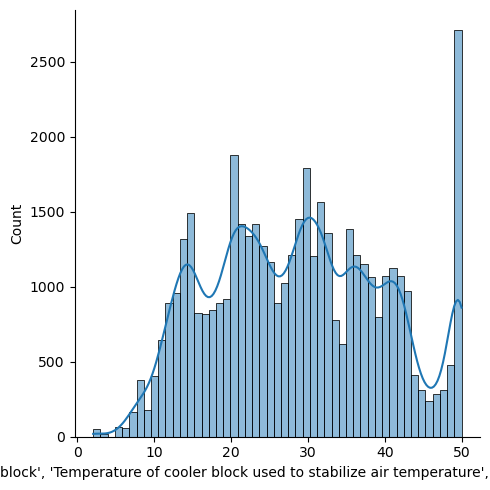

Visualizing ('Tleaf', 'Leaf surface temperature', 'degree_C')


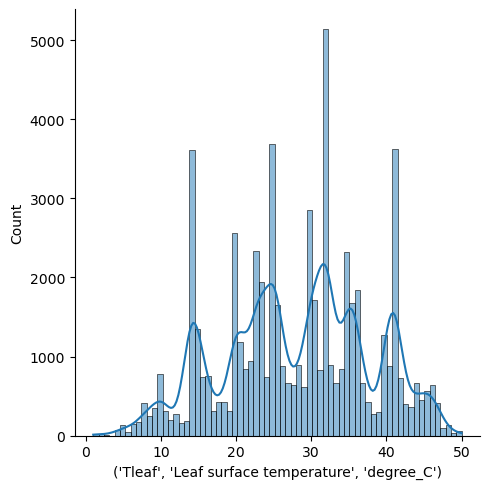

Visualizing ('plantBiome', 'Classification of the biome based on climate and ecological characteristics, such as arctic, boreal, temperate, or tropical', 1)


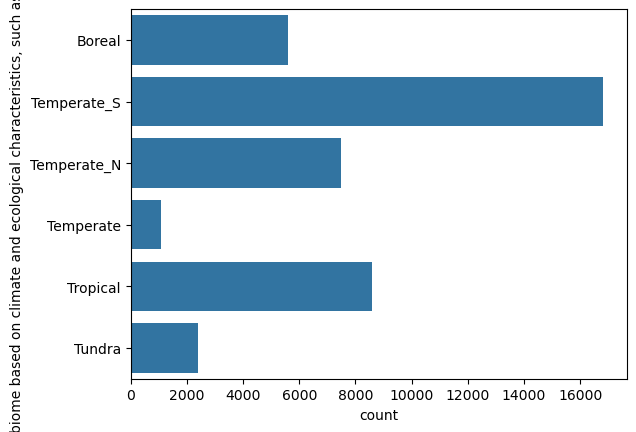

Visualizing ('plantType', 'Classification of plant as either gymnosperm or angiosperm, indicating differences in reproductive structures and evolutionary lineage', 1)


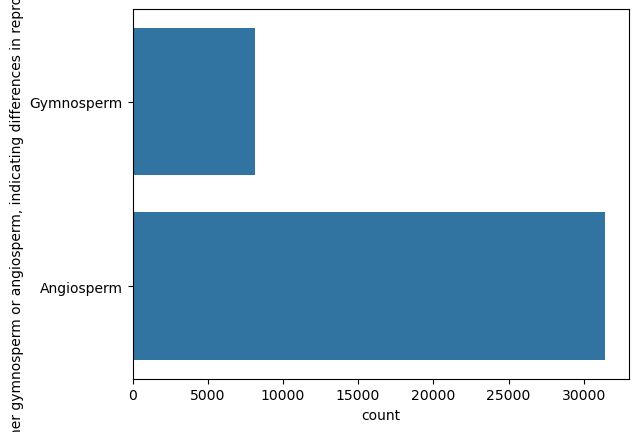

Visualizing ('VPDleaf', 'Leaf to air vapor pressure deficit', 'kPa')


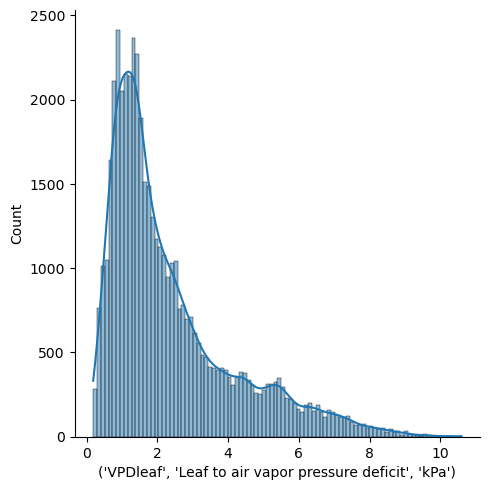

In [30]:
# Iterate over filtered_standard_data columns and visualize
for col in filtered_standard_data.columns:
    print(f"Visualizing {col}")
    funcs.visualize_all_columns(filtered_standard_data[col])

---
---
## 4. Quality Control

---
### 4.1. Strings

In [31]:
# general string cleaning
def clean_string_columns(df):
    # Select only object (string) dtype columns
    string_columns = df.select_dtypes(include=['object']).columns
    df.loc[:, string_columns] = df.loc[:, string_columns].apply(lambda col: col.str.strip().str.lower().str.replace('_', ' '))
    return df

# Apply the function to your DataFrame
filtered_standard_data = clean_string_columns(filtered_standard_data)

In [32]:
# Replace specific values with None
values_to_replace = [-999, -9999, 'none', 'None', np.nan]
filtered_standard_data = filtered_standard_data.replace(values_to_replace, None)

---
### 4.2. Measurement device
There is no measurement device column. This should be found and added to metadata

In [33]:
# most everything is licor 6400
filtered_standard_data[('measurementDevice', 'Name of the instrument that collected data', 1)] = 'licor 6400'
# but 'maritime pine, france' = 'walz-cms'
condition = filtered_standard_data[('siteIdentifier', 'Location descriptor of where data was collected', 1)] == 'maritime pine, france'
filtered_standard_data.loc[condition, ('measurementDevice', 'Name of the instrument that collected data', 1)] = 'walz-cms'

---
### 4.3. Season
This should be calculated where possible

In [34]:
# replace summer a and b with just summer
replacements = {'summer a':'summer', 'summer b':'summer'}
filtered_standard_data[('season', 
                        'Season when the measurement was collected', 
                        1)] = filtered_standard_data[('season', 
                                                      'Season when the measurement was collected', 
                                                      1)].replace(replacements)

---
### 4.4. Growth Environment
Options: open, open top chamber, free-air co2 enrichment system, whole-tree chamber, greenhouse, nursery

In [35]:
filtered_standard_data[('growthEnvironment', 
                        'Growth conditions of the plant, indicating whether it is growing under ambient (normal) or stressed conditions', 
                        1)].unique()
replacements = {'field (ne)':'open',
                'field (cg)':'open',
                'whole tree chambers':'whole-tree chamber',
                'field':'open',
                'growth chamber':'open top chamber',
                'glasshouse':'greenhouse'}
filtered_standard_data[('growthEnvironment', 
                        'Growth conditions of the plant, indicating whether it is growing under ambient (normal) or stressed conditions', 
                        1)] = filtered_standard_data[('growthEnvironment', 
                                                     'Growth conditions of the plant, indicating whether it is growing under ambient (normal) or stressed conditions', 
                                                     1)].replace(replacements)

---
### 4.5. Site Identifier
Need to drop the species information from it

In [36]:
filtered_standard_data[('siteIdentifier', 
                        'Location descriptor of where data was collected', 
                        1)].unique()

array(['black spruce, on, canada', 'black spruce, usa-mn',
       'corymbia calophylla provs, au-nsw', 'dillaway dbf spp, usa-il',
       'dillaway dbf spp, usw-wi (n)', 'dillaway dbf spp, usw-wi (s)',
       'dreyer dbf spp, france', 'english oak, germany',
       'eucalypt woodland, au-nsw', 'eucalyptus globulus, au-nsw',
       'eucalyptus parramattensis, au-nsw', 'eucalyptus saligna, au-nsw',
       'eucalyptus tereticornis provs au-nsw',
       'eucalyptus tereticornis, au-nsw', 'european beech, germany',
       'hinoki cypress, japan', 'japanese beech, japan',
       'lin eucalypt spp, au-nsw', 'loblolly pine, us-nc',
       'maritime pine, france', 'mongolian oak, japan',
       'monterey pine, new zeland', 'norway spruce, sweden', 'peach',
       'rainforest understorey, puerto rico', 'rainforest, au-qld',
       'rainforest, brazil', 'rainforest, panama (a)',
       'rainforest, puerto rico', 'red pine, japan',
       'savanna eucalypt, au-nt', 'scots pine, finland',
       's

In [37]:
replacements = {'black spruce, on, canada':'ontario, canada',
                'black spruce, usa-mn':'minnesota, usa',
                'corymbia calophylla provs, au-nsw':'new south whales, australia', 
                'dillaway dbf spp, usa-il':'illinois, usa',
                'dillaway dbf spp, usw-wi (n)':'wisconsin, usa', 
                'dillaway dbf spp, usw-wi (s)':'wisconsin, usa',
                'dreyer dbf spp, france':'france', 
                'english oak, germany':'germany',
                'eucalypt woodland, au-nsw':'new south whales, australia', 
                'eucalyptus globulus, au-nsw':'new south whales, australia',
                'eucalyptus parramattensis, au-nsw':'new south whales, australia', 
                'eucalyptus saligna, au-nsw':'new south whales, australia',
                'eucalyptus tereticornis provs au-nsw':'new south whales, australia',
                'eucalyptus tereticornis, au-nsw':'new south whales, australia', 
                'european beech, germany':'germany',
                'hinoki cypress, japan':'japan', 
                'japanese beech, japan':'japan',
                'lin eucalypt spp, au-nsw':'new south whales, australia', 
                'loblolly pine, us-nc':'north carolina, usa',
                'maritime pine, france':'france', 
                'mongolian oak, japan':'japan',
                'monterey pine, new zeland':'new zealand', 
                'norway spruce, sweden':'sweden',
                'rainforest understorey, puerto rico':'puerto rico', 
                'rainforest, au-qld':'queensland, australia',
                'rainforest, brazil':'brazil', 
                'rainforest, panama (a)':'panama',
                'rainforest, puerto rico':'puerto rico', 
                'red pine, japan':'japan',
                'savanna eucalypt, au-nt':'northen territory, australia', 
                'scots pine, finland':'finland',
                'scots pine, sweden':'sweden', 
                'semi-arid woodland, au-wa':'western australia, australia',
                'silver birch, finland':'finland', 
                'smith c3 spp, in, usa':'indiana, usa',
                'subalpine eucalypt, au-nsw (a)':'new south whales, australia', 
                'tundra usa-ak':'alaska, usa',
                'vårhammar ebf spp, rwanda':'rwanda', 
                'eucalyptus globulus, au-tas':'tasmania, australia',
                'ghannoum eucalypt spp, au-nsw':'new south whales, australia', 
                'pinus sylvestris provs, usa-wi':'wisconsin, usa'}

filtered_standard_data[('siteIdentifier', 
                        'Location descriptor of where data was collected', 
                        1)] = filtered_standard_data[('siteIdentifier', 
                                                      'Location descriptor of where data was collected', 
                                                      1)].replace(replacements)

---
### 4.6. Plant Form

In [38]:
filtered_standard_data[('plantForm', 
                        'Life form of the plant, categorizing it as tree, shrub, grass, crop, savanna, etc., based on growth form and ecological function', 
                        1)].unique()

array(['net b', 'bet te', 'bdt te', 'net te', 'bet tr', None, 'arctic'],
      dtype=object)

In [39]:
replacements = {'net b': 'needleleaf evergreen tree',
                'bet te': 'broadleaf evergreen tree',
                'bdt te': 'broadleaf deciduous tree',
                'net te': 'needleleaf evergreen tree',
                'bet tr': 'broadleaf evergreen tree',
                'arctic': 'tundra'}

filtered_standard_data[('plantForm', 
                        'Life form of the plant, categorizing it as tree, shrub, grass, crop, savanna, etc., based on growth form and ecological function', 
                        1)] = filtered_standard_data[('plantForm', 
                                                      'Life form of the plant, categorizing it as tree, shrub, grass, crop, savanna, etc., based on growth form and ecological function', 
                                                      1)].replace(replacements)

---
### 4.7. Plant Biome

In [40]:
filtered_standard_data[('plantBiome',
                        'Classification of the biome based on climate and ecological characteristics, such as arctic, boreal, temperate, or tropical', 
                        1)].unique()

array(['boreal', 'temperate s', 'temperate n', 'temperate', 'tropical',
       None, 'tundra'], dtype=object)

In [41]:
replacements = {'temperate s':'temperate',
                'temperate n':'temperate'}
filtered_standard_data[('plantBiome',
                        'Classification of the biome based on climate and ecological characteristics, such as arctic, boreal, temperate, or tropical', 
                        1)] = filtered_standard_data[('plantBiome',
                                                      'Classification of the biome based on climate and ecological characteristics, such as arctic, boreal, temperate, or tropical', 
                                                      1)].replace(replacements)

---
### 4.8. Experimental Manipulation
ambient, co2, shading, water, ozone, co2, temperature

In [42]:
filtered_standard_data[('experimentalManipulation', 
                        'Experimental treatment(s) applied to the plant', 
                        1)].unique()

array(['co2 treatment: none, temp treatment: 22c, water treatment: none',
       'co2 treatment: none, temp treatment: 30c, water treatment: none',
       'co2 treatment: none, temp treatment: none, water treatment: none',
       'co2 treatment: none, temp treatment: 26c, water treatment: none',
       'co2 treatment: none, temp treatment: 32c, water treatment: none',
       'co2 treatment: ambient, temp treatment: none, water treatment: none',
       'co2 treatment: ambient, temp treatment: elevated, water treatment: none',
       'co2 treatment: ambient, temp treatment: ambient, water treatment: none',
       'co2 treatment: elevated, temp treatment: ambient, water treatment: none',
       'co2 treatment: elevated, temp treatment: elevated, water treatment: none',
       'co2 treatment: none, temp treatment: ambient, water treatment: none',
       'co2 treatment: none, temp treatment: elevated, water treatment: none',
       'co2 treatment: ambient, temp treatment: none, water treatm

In [43]:
replacements = {'co2 treatment: none, temp treatment: 22c, water treatment: none':'temperature',
       'co2 treatment: none, temp treatment: 30c, water treatment: none':'temperature',
       'co2 treatment: none, temp treatment: none, water treatment: none':'ambient',
       'co2 treatment: none, temp treatment: 26c, water treatment: none':'temperature',
       'co2 treatment: none, temp treatment: 32c, water treatment: none':'temperature',
       'co2 treatment: ambient, temp treatment: none, water treatment: none':'ambient',
       'co2 treatment: ambient, temp treatment: elevated, water treatment: none':'temperature',
       'co2 treatment: ambient, temp treatment: ambient, water treatment: none':'ambient',
       'co2 treatment: elevated, temp treatment: ambient, water treatment: none':'co2',
       'co2 treatment: elevated, temp treatment: elevated, water treatment: none':'co2 and temperature',
       'co2 treatment: none, temp treatment: ambient, water treatment: none':'ambient',
       'co2 treatment: none, temp treatment: elevated, water treatment: none':'temperature',
       'co2 treatment: ambient, temp treatment: none, water treatment: wet':'water',
       'co2 treatment: elevated, temp treatment: none, water treatment: wet':'co2 and water',
       'co2 treatment: elevated, temp treatment: none, water treatment: dry':'co2 and water',
       'co2 treatment: ambient, temp treatment: none, water treatment: dry':'water',
       'co2 treatment: none, temp treatment: 28.5c, water treatment: none':'temperature',
       'co2 treatment: none, temp treatment: 35.5c, water treatment: none':'temperature',
       'co2 treatment: none, temp treatment: 18c, water treatment: none':'temperature',
       'co2 treatment: none, temp treatment: 15c, water treatment: none':'temperature',
       'co2 treatment: none, temp treatment: 20c, water treatment: none':'temperature',
       'co2 treatment: none, temp treatment: 35c, water treatment: none':'temperature',
       'co2 treatment: none, temp treatment: 25c, water treatment: none':'temperature',
       'co2 treatment: none, temp treatment: 18c, water treatment: wet':'temperature',
       'co2 treatment: none, temp treatment: 21.5c, water treatment: wet':'temperature and water',
       'co2 treatment: none, temp treatment: 25c, water treatment: wet':'temperature and water',
       'co2 treatment: none, temp treatment: 32c, water treatment: wet':'temperature and water',
       'co2 treatment: none, temp treatment: 28.5c, water treatment: wet':'temperature and water',
       'co2 treatment: none, temp treatment: 35.5c, water treatment: wet':'temperature and water',
       'co2 treatment: sub ambient, temp treatment: elevated, water treatment: none':'co2 and temperature',
       'co2 treatment: sub ambient, temp treatment: ambient, water treatment: none':'co2 and temperature',
       'co2 treatment: none, temp treatment: 17c, water treatment: none':'temperature',
       'co2 treatment: none, temp treatment: 23c, water treatment: none':'temperature'}

filtered_standard_data[('experimentalManipulation', 
                        'Experimental treatment(s) applied to the plant', 
                        1)] = filtered_standard_data[('experimentalManipulation', 
                                                      'Experimental treatment(s) applied to the plant', 
                                                      1)].replace(replacements)

In [44]:
filtered_standard_data[('experimentalManipulation', 
                        'Experimental treatment(s) applied to the plant', 
                        1)].unique()

array(['temperature', 'ambient', 'co2', 'co2 and temperature', 'water',
       'co2 and water', 'temperature and water'], dtype=object)

---
### 4.9. Dates/Times

In [45]:
filtered_standard_data[('date', 'Date of observation', 1)].unique()

array([None, '9/07/2014', '8/07/2014', '7/07/2014', 'aug-07',
       '14/07/1995', '12/07/1995', '23/07/1995', '13/07/1995',
       '15/07/1995', '16/07/1995', '18/07/1995', '19/07/1995',
       '26/07/1994', '28/07/1994', '29/07/1994', '1/08/1994', '4/08/1994',
       '25/07/1994', '27/07/1994', '30/07/1994', '2/08/1994',
       '22/07/1995', '17/07/1995', '24/07/1994', '31/07/1994',
       '3/08/1994', '20/07/1995', '12/08/1997', '13/08/1997',
       '14/08/1997', '15/08/1997', '16/08/1997', '17/08/1997',
       '18/08/1997', '20/08/1997', '21/08/1997', '22/08/1997',
       '3/12/2010', '10/12/2010', '9/12/2010', '8/12/2010', '6/12/2010',
       '2/12/2010', '7/12/2010', '10/02/2011', '9/02/2011', '14/02/2011',
       '11/02/2011', '12/02/2011', '15/02/2011', '26/08/2011',
       '29/08/2011', '2/09/2011', '5/09/2011', '1/09/2011', '8/09/2011',
       '20/04/2011', '18/04/2011', '19/04/2011', '7/07/2016',
       '11/07/2016', '12/07/2016', '13/12/2016', '14/12/2016',
       '15/12/20

In [46]:
grouped = filtered_standard_data.groupby([('dataContributor', 
                                           'Name of the individual or organization that contributed to the data', 
                                           1),
                                          ('siteIdentifier', 'Location descriptor of where data was collected', 1)])[[('date', 'Date of observation', 1)]].agg(lambda x: x.unique())
grouped.columns = grouped.columns.get_level_values(0)
grouped = grouped.reset_index()
grouped['source'] = grouped[('dataContributor', 'Name of the individual or organization that contributed to the data', 1)] +  ' ' + grouped[('siteIdentifier', 'Location descriptor of where data was collected', 1)]

In [47]:
grouped = grouped.drop(columns=[('dataContributor', 'Name of the individual or organization that contributed to the data', 1),
                                ('siteIdentifier', 'Location descriptor of where data was collected', 1)])
grouped = grouped[['source', 'date']]
grouped['datetime_formats'], grouped['time_formats'], grouped['dayfirst'] = None, None, None
grouped.index.name = ''
grouped.to_csv(f'../data/temp/datetimes/{filename}_datetime_formatting_temp.csv')

In [48]:
df = pd.read_csv(f'../data/temp/datetimes/{filename}_datetime_formatting.csv', index_col=0, encoding='utf-8')
df.head(3)

,source,date,datetime_formats,time_formats,dayfirst
0,a. s. walcroft new zealand,[None],[],[],[]
1,a. s. walcroft peach,['apr-may/1999'],[‘range_of_months’],[],[]
2,"alistair rogers alaska, usa",[None],[],[],[]


In [49]:
# convert the df into a dictionary format
source_formats = {
    row["source"]: {
        "datetime_formats": eval(row["datetime_formats"].replace("‘", "'").replace("’", "'")),
        "time_formats": eval(row["time_formats"]),
        "dayfirst": eval(row["dayfirst"])
    }
    for _, row in df.iterrows()
}

# add source to filtered_standard_data
filtered_standard_data[("source", "dummy description", 1)] = (
    filtered_standard_data[("dataContributor", "Name of the individual or organization that contributed to the data", 1)]
    + " " +
    filtered_standard_data[("siteIdentifier", "Location descriptor of where data was collected", 1)]
)

# add missing time column
filtered_standard_data[('time', 'Time of observation', 1)] = None

In [50]:
# apply processing by group
results = []
for source, group in filtered_standard_data.groupby(("source", "dummy description", 1)):
    formats = source_formats.get(source, {})
    group[[('original_date', 'Original date', 1), ('original_time', 'Original time', 1), ('year', 'Year of observation', 1), ('month', 'Month of observation', 1), ('day', 'Day of observation', 1), ('time', 'Time of observation', 1)]] = group.apply(
        lambda x: pd.Series(funcs.process_datetime(x, formats)), axis=1
    )
    results.append(group)

# Concatenate the processed groups
filtered_standard_data2 = pd.concat(results)
filtered_standard_data2.head(3)

/var/folders/3s/1n6wl8w52cb_9hst_c95fb9h0000gp/T/ipykernel_66274/2432514997.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  filtered_standard_data2 = pd.concat(results)


standard_variable,record,Ci,experimentalManipulation,CO2r,CO2s,gsw,dataContributor,siteIdentifier,date,growthEnvironment,...,plantType,VPDleaf,measurementDevice,source,time,original_date,original_time,year,month,day
standard_description,Observation record number,Intercellular CO2 concentration in air,Experimental treatment(s) applied to the plant,CO2 concentration in wet air entering chamber,CO2 concentration in wet air inside chamber,Stomatal conductance to water vapor per leaf area,Name of the individual or organization that contributed to the data,Location descriptor of where data was collected,Date of observation,"Growth conditions of the plant, indicating whether it is growing under ambient (normal) or stressed conditions",...,"Classification of plant as either gymnosperm or angiosperm, indicating differences in reproductive structures and evolutionary lineage",Leaf to air vapor pressure deficit,Name of the instrument that collected data,dummy description,Time of observation,Original date,Original time,Year of observation,Month of observation,Day of observation
unit,1,μmol mol-1,1,μmol mol-1,μmol mol-1,mmol m-2 s-1,1,1,1,1,...,1,kPa,1,1,1,1,1,1,1,1
23925,"chamber: none, curve id: 1.0, curve number: 23...",65.2,ambient,None,62.3,0.0702,a. s. walcroft,new zealand,None,greenhouse,...,gymnosperm,0.695,licor 6400,a. s. walcroft new zealand,None,None,None,NaN,NaN,NaN
23926,"chamber: none, curve id: 1.0, curve number: 23...",63.8,ambient,None,61.9,0.0701,a. s. walcroft,new zealand,None,greenhouse,...,gymnosperm,0.695,licor 6400,a. s. walcroft new zealand,None,None,None,NaN,NaN,NaN
23927,"chamber: none, curve id: 1.0, curve number: 23...",91.4,ambient,None,103.7,0.0889,a. s. walcroft,new zealand,None,greenhouse,...,gymnosperm,0.671,licor 6400,a. s. walcroft new zealand,None,None,None,NaN,NaN,NaN


---
### 4.10. Species names
For this Lin 2015 data, I wanted a visual aid to make sure I was adjusting species names correctly, so I generated a unique ID for each data source and species. That way, I can capture when a data source recorded information for multiple species

In [51]:
filtered_standard_data2[('species', 'Full species name and subspecies if applicable', 1)].unique()

array(['pinus radiata', 'prunus persica', 'arctagrostis latifolia',
       'arctophila fulva', 'carex aquatilis', 'dupontia fisheri',
       'eriophorum angustifolium', 'petasites frigidus', 'salix pulchra',
       'carapa grandiflora', 'cedrela serrata',
       'entandrophragma excelsum', 'eucalyptus maidenii',
       'eucalyptus microcorys', 'hagenia abyssinica', 'picea mariana',
       'pinus pinaster (prov landes)', 'pinus pinaster (prov tamjoute)',
       'eucalyptus delegatensis', 'pinus taeda',
       'eucalyptus parramattensis', 'betula papyrifera',
       'liquidambar styraciflua', 'populus deltoides',
       'populus tremuloides', 'abuta cf. panurensis',
       'bellucia dichotoma', 'bertholletia excelsa',
       'brosimum parinarioides ssp. parinariodes', 'couepia longipondula',
       'crysophillum sp.', 'diospyrus cf. praetermissa',
       'eschweilera coriacea', 'guarea sp.', 'jacaranda copaia',
       'licania micheli carobe', 'licania octandra', 'macherium sp.',
       

In [52]:
# instantiate species checklist
u_species = filtered_standard_data2[[('species', 'Full species name and subspecies if applicable', 1),
                       ('plantType', 'Classification of plant as either gymnosperm or angiosperm, indicating differences in reproductive structures and evolutionary lineage', 1),
                       ('plantLeaf', 'Leaf lifespan strategy of the plant, categorizing it as evergreen or deciduous based on leaf retention patterns', 1),
                       ('plantForm', 'Life form of the plant, categorizing it as tree, shrub, grass, crop, savanna, etc., based on growth form and ecological function', 1)]].drop_duplicates()
u_species.columns = u_species.columns.get_level_values(0)
u_species = u_species.rename(columns={'species':'unadjudicatedName'})
u_species = u_species.sort_values(by='unadjudicatedName')
u_species

standard_variable,unadjudicatedName,plantType,plantLeaf,plantForm
27300,abuta cf. panurensis,angiosperm,evergreen,broadleaf evergreen tree
30863,acacia aneura,angiosperm,evergreen,broadleaf evergreen tree
31125,acacia hemiteles,angiosperm,evergreen,broadleaf evergreen tree
8778,acer pseudoplatanus,angiosperm,deciduous,broadleaf deciduous tree
32853,acer rubrum,None,None,None
...,...,...,...,...
60513,vantanea depleta,angiosperm,evergreen,broadleaf evergreen tree
60562,virola multiflora,angiosperm,evergreen,broadleaf evergreen tree
60713,vochysia ferruginea,angiosperm,evergreen,broadleaf evergreen tree
61713,zuelania guidonia,angiosperm,evergreen,broadleaf evergreen tree


---
#### 4.10.1 Instantiate the species lookup table as `filename_species_lookup.csv`

In [53]:
# add missing columns
u_species['acceptedName'] = None
u_species['nameAuthor'] = None
u_species['nameAuthority'] = None
u_species['nameCategory'] = None
u_species['nameAdjudicator'] = None

# export checklist
u_species.to_csv(f'../data/temp/species/{filename}_species_lookup.csv')

---
### 4.10.2 Fill in the lookup table information save as `filename_species_lookup_01.csv`
We recommend passing this task on to an expert who can parse through synonymous, mispelled, and misapplied names

In [54]:
# load edited species checklist (species_checklist_01)
species_checklist = pd.read_csv(f'../data/temp/species/{filename}_species_lookup_01.csv', index_col=0)
species_checklist = species_checklist.replace({np.nan: None})
species_checklist

,unadjudicatedName,plantType,plantLeaf,plantForm,acceptedName,nameAuthor,nameAuthority,nameCategory,nameAdjudicator
27300,abuta cf. panurensis,angiosperm,evergreen,tree,abuta,None,None,genus,None
30863,acacia aneura,angiosperm,evergreen,tree,acacia aneura,None,None,species,None
31125,acacia hemiteles,angiosperm,evergreen,tree,acacia hemiteles,None,None,species,None
8778,acer pseudoplatanus,angiosperm,deciduous,tree,acer pseudoplatanus,None,None,species,None
32853,acer rubrum,angiosperm,deciduous,tree,acer rubrum,None,None,species,None
...,...,...,...,...,...,...,...,...,...
60513,vantanea depleta,angiosperm,evergreen,tree,vantanea depleta,None,None,species,None
60562,virola multiflora,angiosperm,evergreen,tree,virola multiflora,None,None,species,None
60713,vochysia ferruginea,angiosperm,evergreen,tree,vochysia ferruginea,None,None,species,None
61713,zuelania guidonia,angiosperm,evergreen,tree,zuelania guidonia,None,None,species,None


#### 4.10.3. Format the lookup table headers for merging new columns to the data

In [55]:
# make single headers into multi-headers
new_columns = pd.MultiIndex.from_tuples([
    ('unadjudicatedName', 'Full species name and subspecies if applicable', 1),  # Matching the multi-header in filtered_standard_data2
    ('plantType', 'Classification of plant as either gymnosperm or angiosperm, indicating differences in reproductive structures and evolutionary lineage', 1),
    ('plantLeaf', 'Leaf lifespan strategy of the plant, categorizing it as evergreen or deciduous based on leaf retention patterns', 1),
    ('plantForm', 'Life form of the plant, categorizing it as tree, shrub, grass, crop, savanna, etc., based on growth form and ecological function', 1),
    ('acceptedName', 'The accepted species name assigned by the adjudicator', 1),
    ('nameAuthor', 'The author of the accepted species name', 1),
    ('nameAuthority', 'The authority that was referenced to assign the accepted species name', 1),
    ('nameCategory', 'The taxonomic heirarchy level at which the plant was named (family, genus, species, subspecies, variety, type)', 1),
    ('nameAdjudicator', 'The expert that assigned an unadjudicated species name to an accepted species name', 1)
])
species_checklist.columns = new_columns

#### 4.10.4. Merge the species data to filtered_standard_data

In [56]:
# merge checklist to filtered_standard_data
merged_df = pd.merge(
    filtered_standard_data2,
    species_checklist,
    left_on=[('species', 'Full species name and subspecies if applicable', 1)],
    right_on=[('unadjudicatedName', 'Full species name and subspecies if applicable', 1)],
    how='left'
)

#### 4.10.5. Drop some overlapped columns from the merged dataframe

In [57]:
# rename columns
columns_to_drop = [('plantType_x',
                    'Classification of plant as either gymnosperm or angiosperm, indicating differences in reproductive structures and evolutionary lineage',
                    1),
                   ('plantLeaf_x',
                    'Leaf lifespan strategy of the plant, categorizing it as evergreen or deciduous based on leaf retention patterns',
                    1),
                   ('plantForm_x',
                    'Life form of the plant, categorizing it as tree, shrub, grass, crop, savanna, etc., based on growth form and ecological function',
                    1),
                   ('date', 'Date of observation', 1),
                   ('original_date', 'Original date', 1),
                   ('original_time', 'Original time', 1),
                   ('species', 'Full species name and subspecies if applicable', 1),
                   ('source', 'dummy description', 1)]

# Drop the specified columns
merged_df = merged_df.drop(columns=columns_to_drop, axis=1)
merged_df.columns = pd.MultiIndex.from_tuples([
    (col[0].replace('_y', ''), *col[1:]) for col in merged_df.columns
])
merged_df.head(3)

,record,Ci,experimentalManipulation,CO2r,CO2s,gsw,dataContributor,siteIdentifier,growthEnvironment,A,...,day,unadjudicatedName,plantType,plantLeaf,plantForm,acceptedName,nameAuthor,nameAuthority,nameCategory,nameAdjudicator
,Observation record number,Intercellular CO2 concentration in air,Experimental treatment(s) applied to the plant,CO2 concentration in wet air entering chamber,CO2 concentration in wet air inside chamber,Stomatal conductance to water vapor per leaf area,Name of the individual or organization that contributed to the data,Location descriptor of where data was collected,"Growth conditions of the plant, indicating whether it is growing under ambient (normal) or stressed conditions",Net CO2 exchange per leaf area,...,Day of observation,Full species name and subspecies if applicable,"Classification of plant as either gymnosperm or angiosperm, indicating differences in reproductive structures and evolutionary lineage","Leaf lifespan strategy of the plant, categorizing it as evergreen or deciduous based on leaf retention patterns","Life form of the plant, categorizing it as tree, shrub, grass, crop, savanna, etc., based on growth form and ecological function",The accepted species name assigned by the adjudicator,The author of the accepted species name,The authority that was referenced to assign the accepted species name,"The taxonomic heirarchy level at which the plant was named (family, genus, species, subspecies, variety, type)",The expert that assigned an unadjudicated species name to an accepted species name
,1,μmol mol-1,1,μmol mol-1,μmol mol-1,mmol m-2 s-1,1,1,1,μmol m-2 s-1,...,1,1,1,1,1,1,1,1,1,1
0,"chamber: none, curve id: 1.0, curve number: 23...",65.2,ambient,None,62.3,0.0702,a. s. walcroft,new zealand,greenhouse,-0.156,...,NaN,pinus radiata,gymnosperm,evergreen,tree,pinus radiata,None,None,species,None
1,"chamber: none, curve id: 1.0, curve number: 23...",63.8,ambient,None,61.9,0.0701,a. s. walcroft,new zealand,greenhouse,-0.114,...,NaN,pinus radiata,gymnosperm,evergreen,tree,pinus radiata,None,None,species,None
2,"chamber: none, curve id: 1.0, curve number: 23...",91.4,ambient,None,103.7,0.0889,a. s. walcroft,new zealand,greenhouse,0.613,...,NaN,pinus radiata,gymnosperm,evergreen,tree,pinus radiata,None,None,species,None


---
---
## 5. Unit conversion

In [58]:
merged_df.columns.tolist()

[('record', 'Observation record number', 1),
 ('Ci', 'Intercellular CO2 concentration in air', 'μmol mol-1'),
 ('experimentalManipulation',
  'Experimental treatment(s) applied to the plant',
  1),
 ('CO2r', 'CO2 concentration in wet air entering chamber', 'μmol mol-1'),
 ('CO2s', 'CO2 concentration in wet air inside chamber', 'μmol mol-1'),
 ('gsw', 'Stomatal conductance to water vapor per leaf area', 'mmol m-2 s-1'),
 ('dataContributor',
  'Name of the individual or organization that contributed to the data',
  1),
 ('siteIdentifier', 'Location descriptor of where data was collected', 1),
 ('growthEnvironment',
  'Growth conditions of the plant, indicating whether it is growing under ambient (normal) or stressed conditions',
  1),
 ('A', 'Net CO2 exchange per leaf area', 'μmol m-2 s-1'),
 ('replicate',
  'Identification number indicating if a plant was measured more than once',
  1),
 ('season', 'Season when the measurement was collected', 1),
 ('latitudeY', 'Latitude coordinate of t

In [59]:
column_data_types = {
    ('record', 'Observation record number', 1):'str',
    ('Ci', 'Intercellular CO2 concentration in air', 'μmol mol-1'):'Float64',
    ('experimentalManipulation', 'Experimental treatment(s) applied to the plant', 1):'str',
    ('CO2r', 'CO2 concentration in wet air entering chamber', 'μmol mol-1'):'Float64',
    ('CO2s', 'CO2 concentration in wet air inside chamber', 'μmol mol-1'):'Float64',
    ('gsw', 'Stomatal conductance to water vapor per leaf area', 'mmol m-2 s-1'):'Float64',
    ('dataContributor', 'Name of the individual or organization that contributed to the data', 1):'str',
    ('siteIdentifier', 'Location descriptor of where data was collected', 1):'str',
    ('growthEnvironment', 'Growth conditions of the plant, indicating whether it is growing under ambient (normal) or stressed conditions', 1):'str',
    ('plantLeaf', 'Leaf lifespan strategy of the plant, categorizing it as evergreen or deciduous based on leaf retention patterns', 1):'str',
    ('plantForm', 'Life form of the plant, categorizing it as tree, shrub, grass, crop, savanna, etc., based on growth form and ecological function', 1):'str',
    ('A', 'Net CO2 exchange per leaf area', 'μmol m-2 s-1'):'Float64',
    ('replicate', 'Identification number indicating if a plant was measured more than once', 1):'str',
    ('season', 'Season when the measurement was collected', 1):'str',
    ('latitudeY', 'Latitude coordinate of the site', 'degree'):'Float64',
    ('longitudeX', 'Longitude coordinate of the site', 'degree'):'Float64',
    ('Tair', 'Air temperature inside the chamber', 'degree_C'):'Float64',
    ('Tblock', 'Temperature of cooler block used to stabilize air temperature', 'degree_C'):'Float64',
    ('Tleaf', 'Leaf surface temperature', 'degree_C'):'Float64',
    ('plantBiome', 'Classification of the biome based on climate and ecological characteristics, such as arctic, boreal, temperate, or tropical', 1):'str',
    ('plantType', 'Classification of plant as either gymnosperm or angiosperm, indicating differences in reproductive structures and evolutionary lineage', 1):'str',
    ('VPDleaf', 'Leaf to air vapor pressure deficit', 'kPa'):'Float64',
    ('measurementDevice', 'Name of the instrument that collected data', 1):'str',
    ('time', 'Time of observation', 1):'str',
    ('year', 'Year of observation', 1):'Int64',
    ('month', 'Month of observation', 1):'Int64',
    ('day', 'Day of observation', 1):'Int64',
    ('unadjudicatedName', 'Full species name and subspecies if applicable', 1):'str',
    ('acceptedName', 'The accepted species name assigned by the adjudicator', 1):'str',
    ('nameAuthor', 'The author of the accepted species name', 1):'str',
    ('nameAuthority', 'The authority that was referenced to assign the accepted species name', 1):'str',
    ('nameCategory', 'The taxonomic heirarchy level at which the plant was named (family, genus, species, subspecies, variety, type)', 1):'str',
    ('nameAdjudicator', 'The expert that assigned an unadjudicated species name to an accepted species name', 1):'str'}

In [60]:
# assign data types
merged_df = merged_df.astype(column_data_types)
merged_df.head(3)

,record,Ci,experimentalManipulation,CO2r,CO2s,gsw,dataContributor,siteIdentifier,growthEnvironment,A,...,day,unadjudicatedName,plantType,plantLeaf,plantForm,acceptedName,nameAuthor,nameAuthority,nameCategory,nameAdjudicator
,Observation record number,Intercellular CO2 concentration in air,Experimental treatment(s) applied to the plant,CO2 concentration in wet air entering chamber,CO2 concentration in wet air inside chamber,Stomatal conductance to water vapor per leaf area,Name of the individual or organization that contributed to the data,Location descriptor of where data was collected,"Growth conditions of the plant, indicating whether it is growing under ambient (normal) or stressed conditions",Net CO2 exchange per leaf area,...,Day of observation,Full species name and subspecies if applicable,"Classification of plant as either gymnosperm or angiosperm, indicating differences in reproductive structures and evolutionary lineage","Leaf lifespan strategy of the plant, categorizing it as evergreen or deciduous based on leaf retention patterns","Life form of the plant, categorizing it as tree, shrub, grass, crop, savanna, etc., based on growth form and ecological function",The accepted species name assigned by the adjudicator,The author of the accepted species name,The authority that was referenced to assign the accepted species name,"The taxonomic heirarchy level at which the plant was named (family, genus, species, subspecies, variety, type)",The expert that assigned an unadjudicated species name to an accepted species name
,1,μmol mol-1,1,μmol mol-1,μmol mol-1,mmol m-2 s-1,1,1,1,μmol m-2 s-1,...,1,1,1,1,1,1,1,1,1,1
0,"chamber: none, curve id: 1.0, curve number: 23...",65.2,ambient,<NA>,62.3,0.0702,a. s. walcroft,new zealand,greenhouse,-0.156,...,<NA>,pinus radiata,gymnosperm,evergreen,tree,pinus radiata,None,None,species,None
1,"chamber: none, curve id: 1.0, curve number: 23...",63.8,ambient,<NA>,61.9,0.0701,a. s. walcroft,new zealand,greenhouse,-0.114,...,<NA>,pinus radiata,gymnosperm,evergreen,tree,pinus radiata,None,None,species,None
2,"chamber: none, curve id: 1.0, curve number: 23...",91.4,ambient,<NA>,103.7,0.0889,a. s. walcroft,new zealand,greenhouse,0.613,...,<NA>,pinus radiata,gymnosperm,evergreen,tree,pinus radiata,None,None,species,None


Visualizing ('record', 'Observation record number', 1)


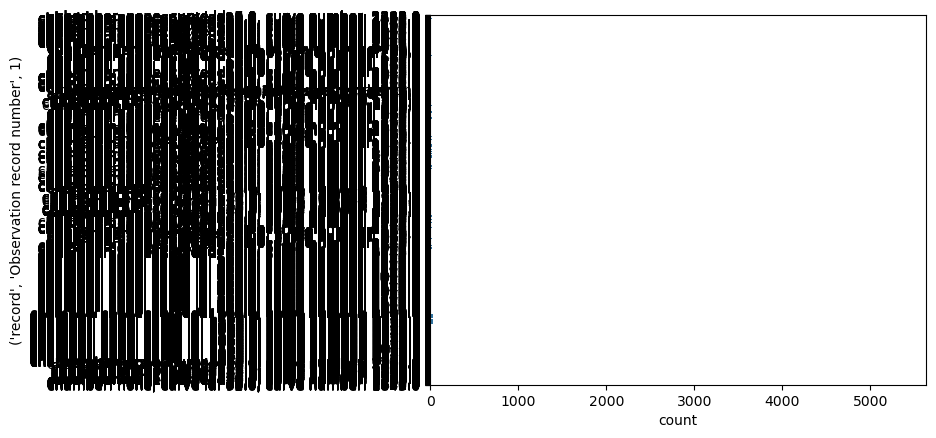

Visualizing ('Ci', 'Intercellular CO2 concentration in air', 'μmol mol-1')


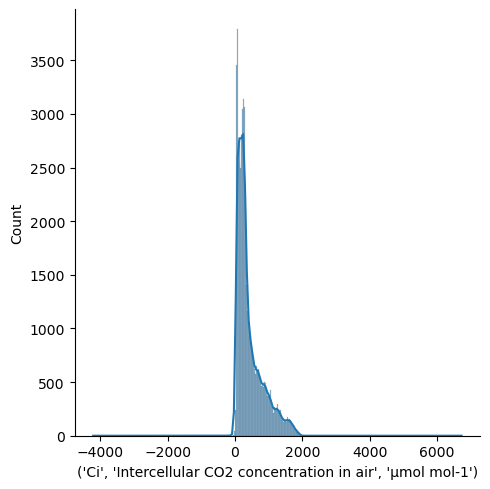

Visualizing ('experimentalManipulation', 'Experimental treatment(s) applied to the plant', 1)


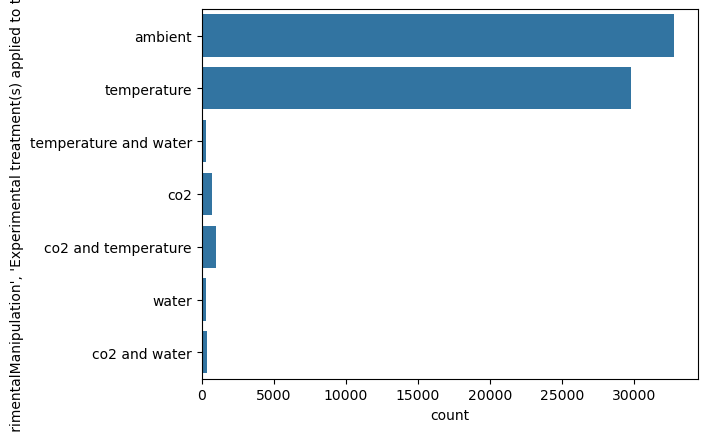

Visualizing ('CO2r', 'CO2 concentration in wet air entering chamber', 'μmol mol-1')


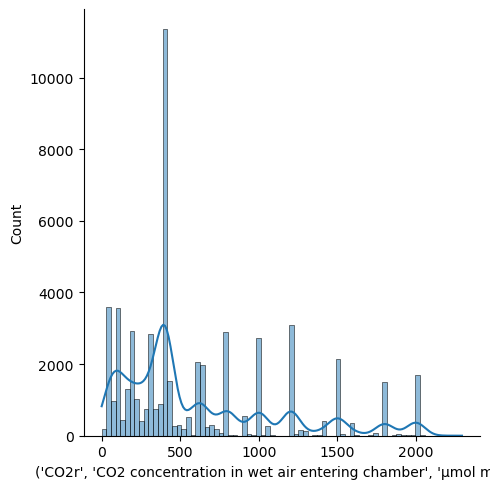

Visualizing ('CO2s', 'CO2 concentration in wet air inside chamber', 'μmol mol-1')


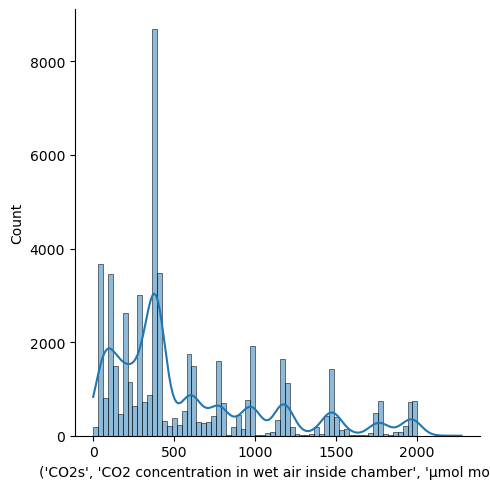

Visualizing ('gsw', 'Stomatal conductance to water vapor per leaf area', 'mmol m-2 s-1')


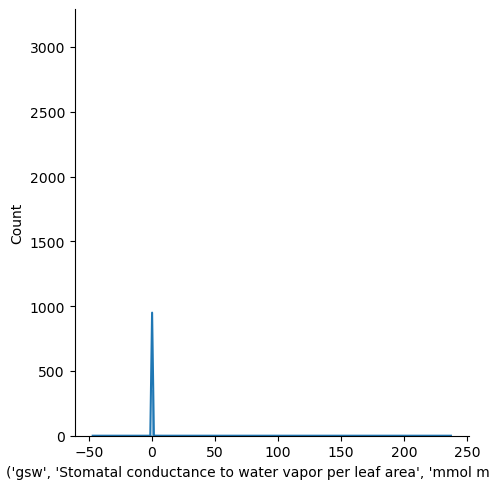

Visualizing ('dataContributor', 'Name of the individual or organization that contributed to the data', 1)


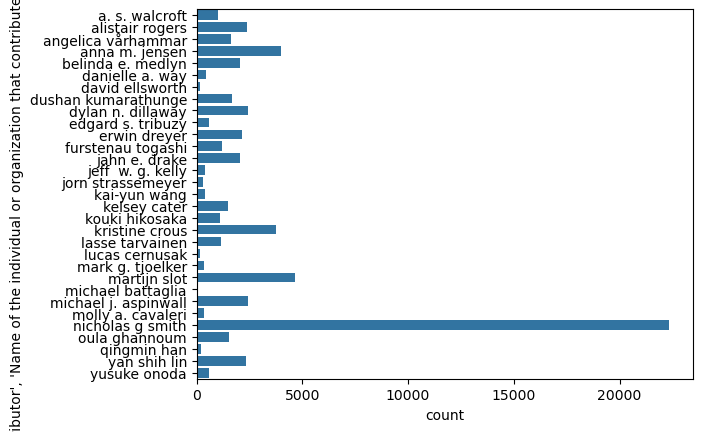

Visualizing ('siteIdentifier', 'Location descriptor of where data was collected', 1)


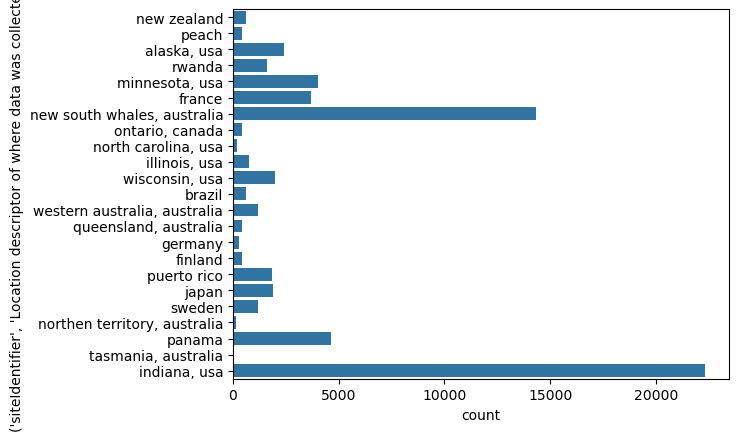

Visualizing ('growthEnvironment', 'Growth conditions of the plant, indicating whether it is growing under ambient (normal) or stressed conditions', 1)


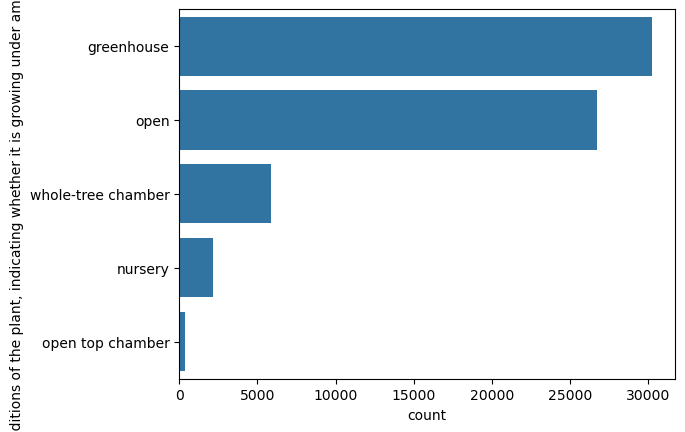

Visualizing ('A', 'Net CO2 exchange per leaf area', 'μmol m-2 s-1')


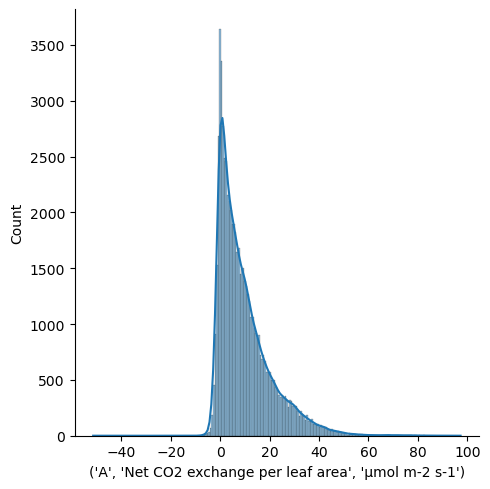

Visualizing ('replicate', 'Identification number indicating if a plant was measured more than once', 1)


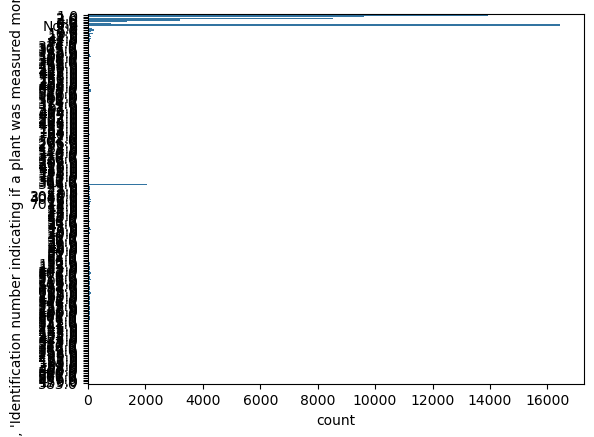

Visualizing ('season', 'Season when the measurement was collected', 1)


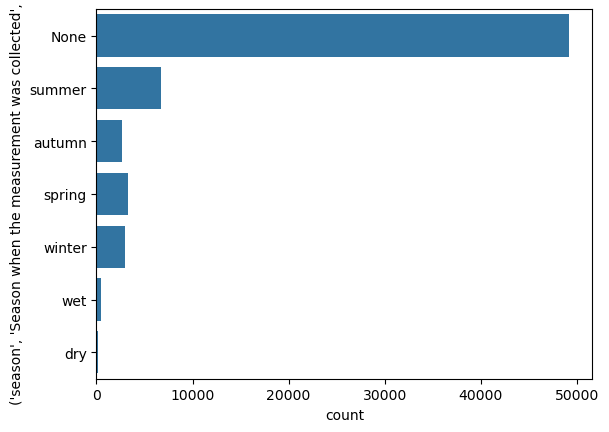

Visualizing ('latitudeY', 'Latitude coordinate of the site', 'degree')


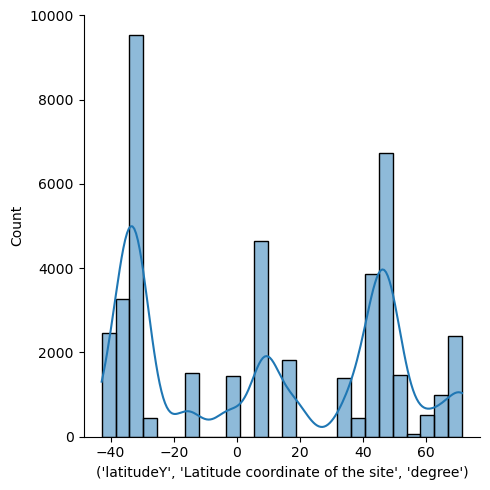

Visualizing ('longitudeX', 'Longitude coordinate of the site', 'degree')


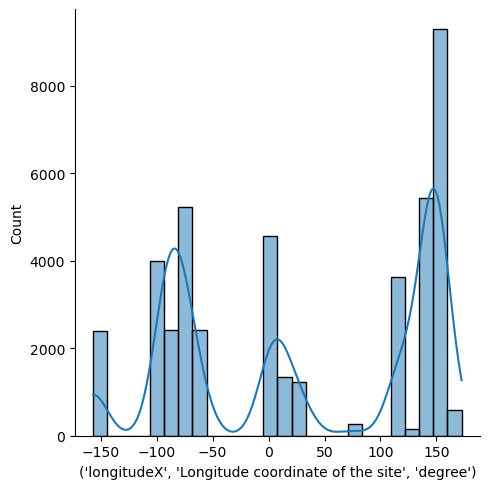

Visualizing ('Tair', 'Air temperature inside the chamber', 'degree_C')


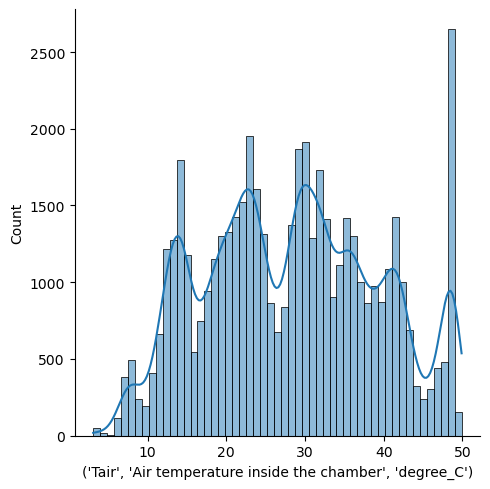

Visualizing ('Tblock', 'Temperature of cooler block used to stabilize air temperature', 'degree_C')


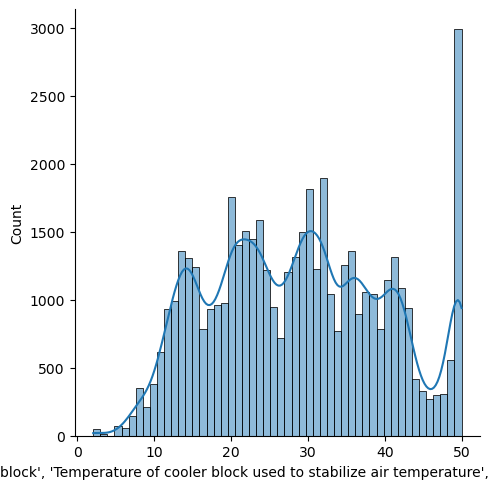

Visualizing ('Tleaf', 'Leaf surface temperature', 'degree_C')


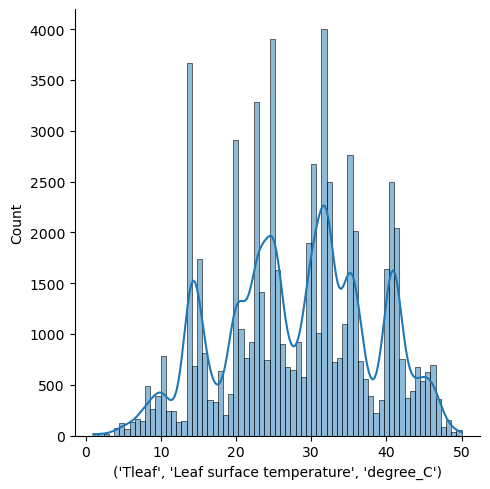

Visualizing ('plantBiome', 'Classification of the biome based on climate and ecological characteristics, such as arctic, boreal, temperate, or tropical', 1)


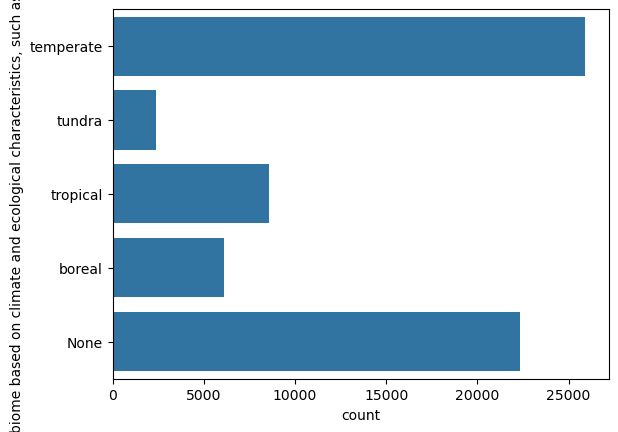

Visualizing ('VPDleaf', 'Leaf to air vapor pressure deficit', 'kPa')


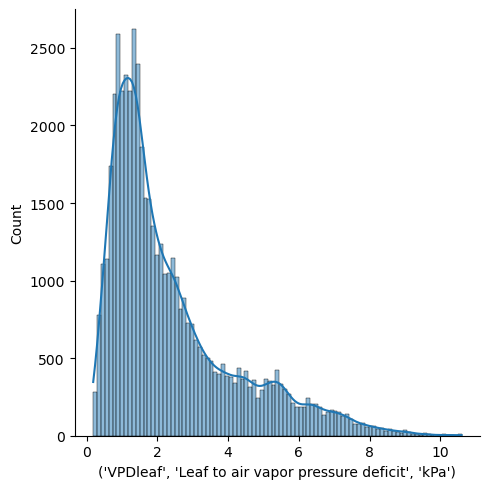

Visualizing ('measurementDevice', 'Name of the instrument that collected data', 1)


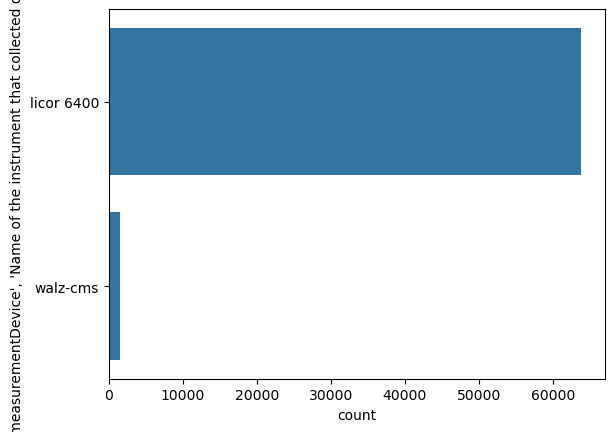

Visualizing ('time', 'Time of observation', 1)


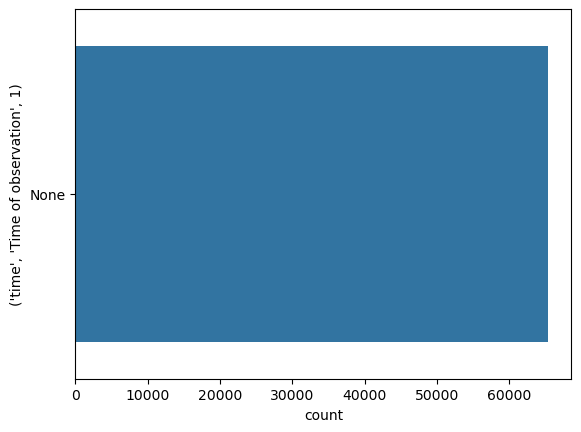

Visualizing ('year', 'Year of observation', 1)


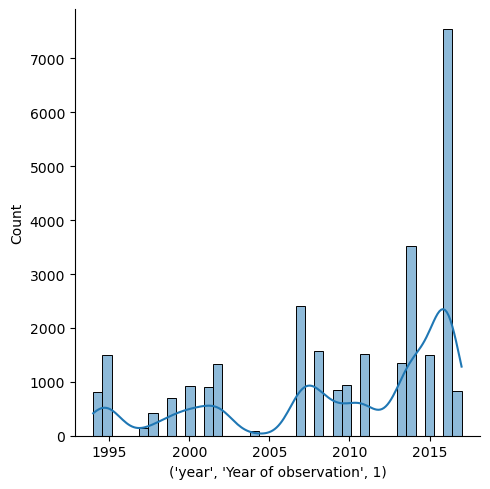

Visualizing ('month', 'Month of observation', 1)


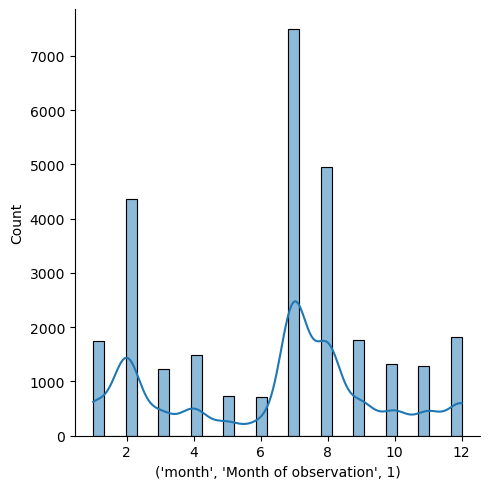

Visualizing ('day', 'Day of observation', 1)


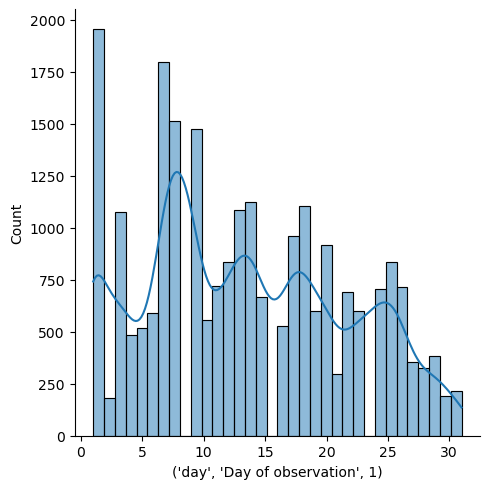

Visualizing ('unadjudicatedName', 'Full species name and subspecies if applicable', 1)


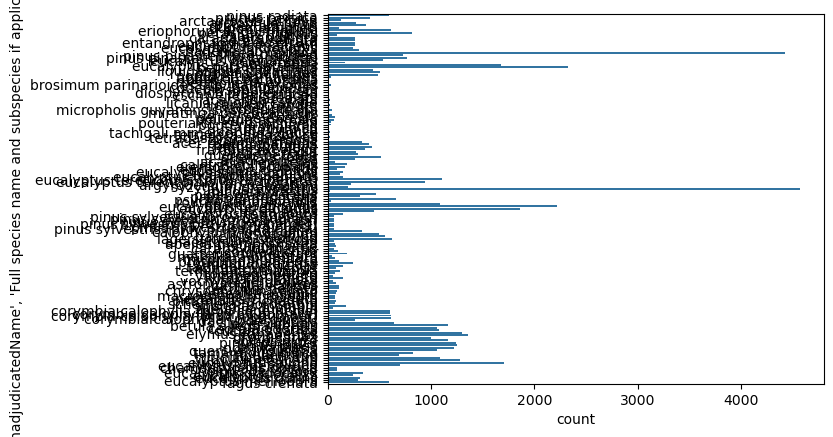

Visualizing ('plantType', 'Classification of plant as either gymnosperm or angiosperm, indicating differences in reproductive structures and evolutionary lineage', 1)


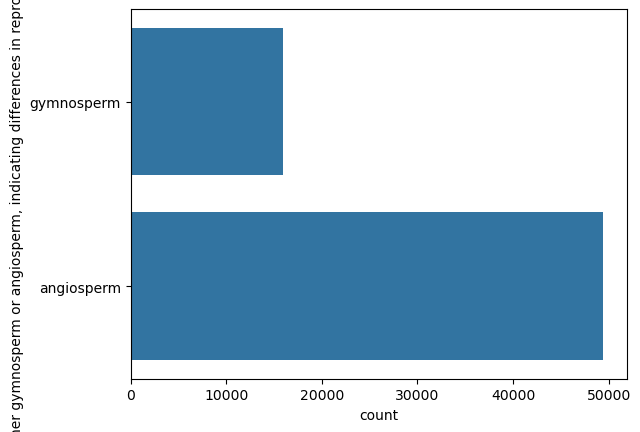

Visualizing ('plantLeaf', 'Leaf lifespan strategy of the plant, categorizing it as evergreen or deciduous based on leaf retention patterns', 1)


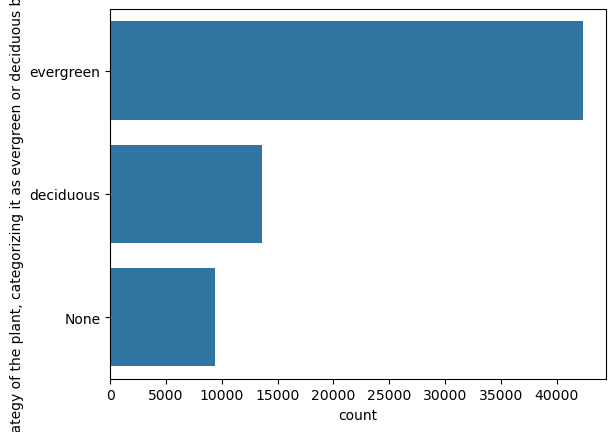

Visualizing ('plantForm', 'Life form of the plant, categorizing it as tree, shrub, grass, crop, savanna, etc., based on growth form and ecological function', 1)


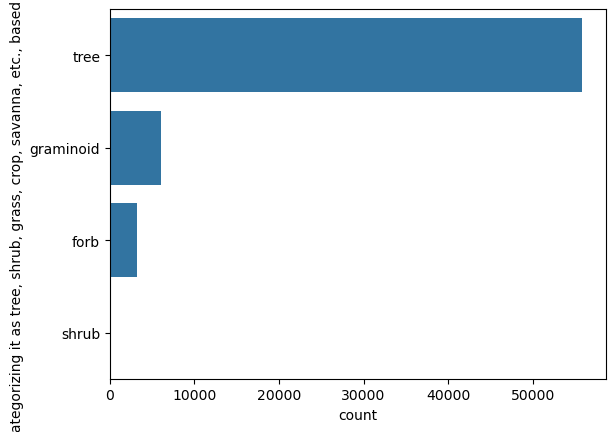

Visualizing ('acceptedName', 'The accepted species name assigned by the adjudicator', 1)


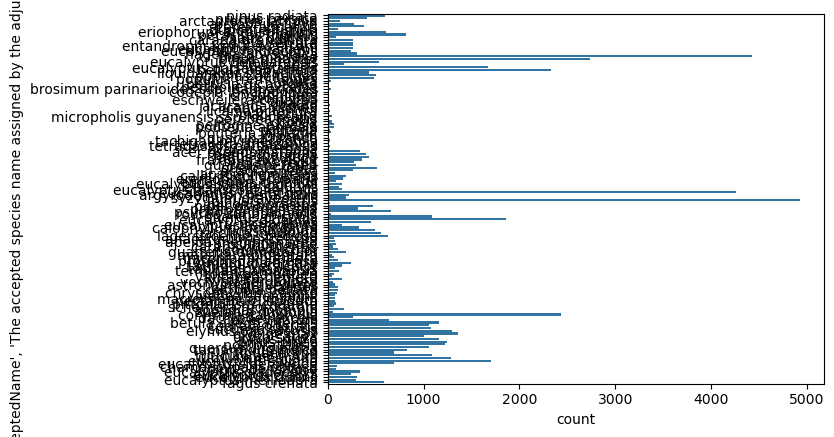

Visualizing ('nameAuthor', 'The author of the accepted species name', 1)


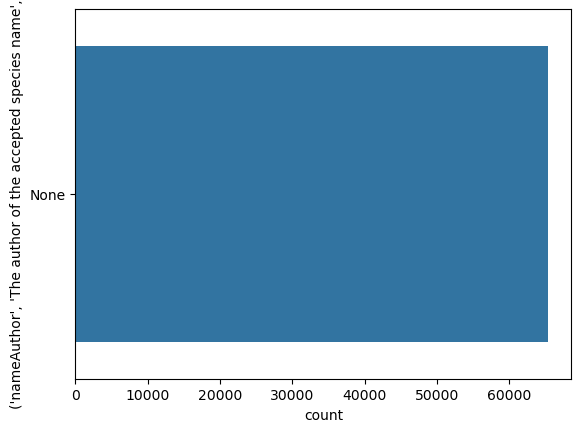

Visualizing ('nameAuthority', 'The authority that was referenced to assign the accepted species name', 1)


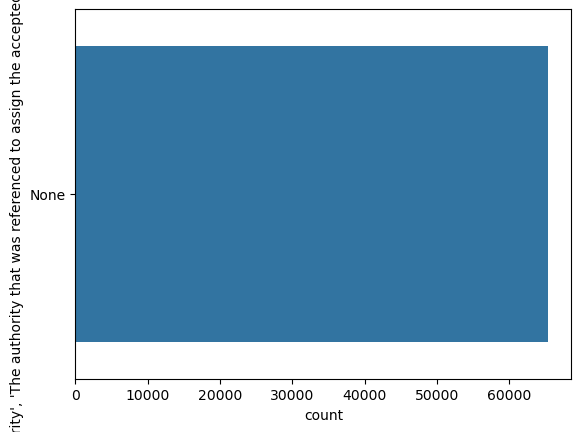

Visualizing ('nameCategory', 'The taxonomic heirarchy level at which the plant was named (family, genus, species, subspecies, variety, type)', 1)


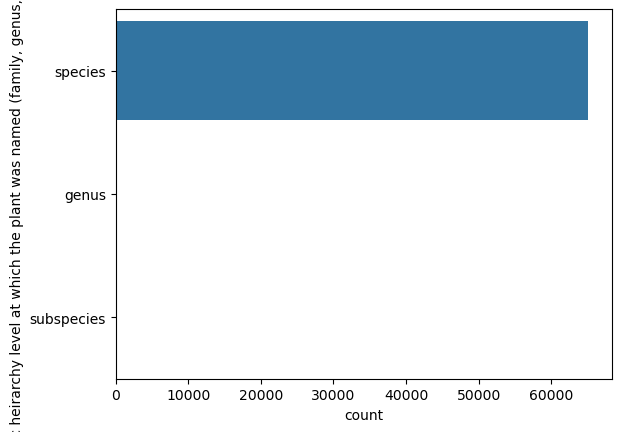

Visualizing ('nameAdjudicator', 'The expert that assigned an unadjudicated species name to an accepted species name', 1)


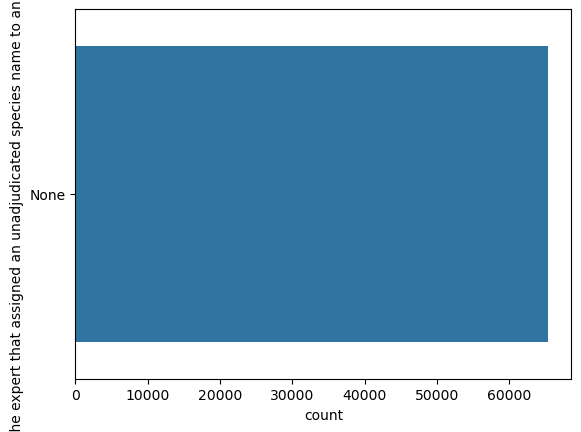

In [61]:
# Iterate over filtered_standard_data columns and visualize
for col in merged_df.columns:
    print(f"Visualizing {col}")
    funcs.visualize_all_columns(merged_df[col])

In [62]:
# Create a deep copy of merged_df
merged_df_2 = merged_df.copy(deep=True)
merged_df_2, preconverted_cols, converted_cols = funcs.check_and_convert_units(column_standards, merged_df_2)

In [63]:
preconverted_cols

[]

---
### 5.1. Visualize and confirm unit conversions

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_comparison(selected_col_1, selected_col_2, col_name):
    """
    Creates a subplot with one row and two columns comparing data from merged_df and filtered_df.
    - Ensures consistent bin sizes across both histograms, while allowing different x-axis ranges.
    
    Parameters:
    selected_col_1 (Series): Data for the left plot (from merged_df).
    selected_col_2 (Series): Data for the right plot (from filtered_df).
    col_name (str): The variable name being compared.
    """
    
    # Drop NaN values only for plotting
    col_1_no_nan = selected_col_1.dropna()
    col_2_no_nan = selected_col_2.dropna()
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f'Comparison of {col_name}', fontsize=16)
    
    # Check if the data is numeric
    if pd.api.types.is_numeric_dtype(col_1_no_nan):
        
        # Determine bin size based on the range of the first dataset
        min1, max1 = col_1_no_nan.min(), col_1_no_nan.max()
        min2, max2 = col_2_no_nan.min(), col_2_no_nan.max()
        
        # Define bin edges
        num_bins = 20
        bin_edges1 = np.linspace(min1, max1, num_bins + 1)
        bin_edges2 = np.linspace(min2, max2, num_bins + 1)

        # Plot numeric data with consistent bin sizes
        sns.histplot(col_1_no_nan, bins=bin_edges1, kde=True, ax=axes[0])
        axes[0].set_title('df1 (Numeric Data)')
        axes[0].axvline(col_1_no_nan.min(), color='green', linestyle='--', label=f'Min: {col_1_no_nan.min():.2f}')
        axes[0].axvline(col_1_no_nan.max(), color='purple', linestyle='--', label=f'Max: {col_1_no_nan.max():.2f}')
        axes[0].legend()

        sns.histplot(col_2_no_nan, bins=bin_edges2, kde=True, ax=axes[1], color='orange')
        axes[1].set_title('df2 (Numeric Data)')
        axes[1].axvline(col_2_no_nan.min(), color='green', linestyle='--', label=f'Min: {col_2_no_nan.min():.2f}')
        axes[1].axvline(col_2_no_nan.max(), color='purple', linestyle='--', label=f'Max: {col_2_no_nan.max():.2f}')
        axes[1].legend()
    
    else:
        # Plot categorical data if not numeric
        sns.countplot(y=col_1_no_nan, ax=axes[0], color='blue', legend=False)
        axes[0].set_title('df1 (Categorical Data)')
        
        sns.countplot(y=col_2_no_nan, ax=axes[1], color='orange', legend=False)
        axes[1].set_title('df2 (Categorical Data)')
    
    # Remove Y-axis labels
    axes[0].set_ylabel('')
    axes[1].set_ylabel('')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Now plot the comparison
for preconv_col, conv_col in zip(preconverted_cols, converted_cols):
    print(f'Visualizing {preconv_col} and {conv_col}')

    try:
        # Select columns using multi-level tuples
        selected_col_1 = merged_df[preconv_col].squeeze()
        selected_col_2 = merged_df_2[conv_col].squeeze()
        
        # Call the comparison plot function
        plot_comparison(selected_col_1, selected_col_2, preconv_col)

    except Exception as e:
        print(f'Could not plot...', e)

---
### 5.2. Drop out-of-range values per ESS-Dive leaf-gas-exchange info

In [65]:
oor = pd.read_csv('../data/supp/info_measured_variables.csv')
oor

,variableName,variableUnit,variableDescription,expectedValueRangeMin,expectedValueRangeMax
0,date,YYYY-MM-DD,Date of observation,NaN,NaN
1,time,HH:MM:SS,Time of observation,NaN,NaN
2,record,1,Observation record number,NaN,NaN
3,area,cm-2,Leaf area,NaN,NaN
4,A,µmol m-2 s-1,Net CO₂ exchange per leaf area,-20.0,120.0
5,Amax,µmol m-2 s-1,Highest rate of light and CO₂ saturated A,-20.0,120.0
6,Asat,µmol m-2 s-1,Highest rate of light saturated A at ambient C...,-20.0,120.0
7,Ci,µmol mol-1,Intercellular CO₂ concentration in air,0.0,5000.0
8,CO2r,µmol mol-1,CO₂ concentration in wet air entering chamber,0.0,5000.0
9,CO2s,µmol mol-1,CO₂ concentration in wet air inside chamber,0.0,5000.0


In [66]:
def filter_out_of_range_data(oor, df):
    """
    Filters out data in merged_df_2 that falls outside the expected value range specified in oor.
    Also handles potential unit errors for specific variables (e.g., Patm in hPa vs. kPa).
    Special case for RH: Values above 100 are capped at 100 instead of being removed.
    
    Parameters:
    oor (DataFrame): Contains columns variableName, variableUnit, variableDescription, 
                     expectedValueRangeMin, expectedValueRangeMax.
    merged_df_2 (DataFrame): A DataFrame with a 3-row multi-header.
    
    Returns:
    filtered_df (DataFrame): A copy of merged_df_2 with out-of-range values removed or capped.
    filtered_columns (list): List of multi-header column names where out-of-range data was removed or capped.
    """
    
    # Create a copy of merged_df_2 to avoid modifying the original DataFrame
    filtered_df = df.copy()

    # List to store multi-header column names where out-of-range data was removed or capped
    filtered_columns = []

    # Iterate over each row in oor
    for _, row in oor.iterrows():
        var_name = row['variableName']
        min_val = row['expectedValueRangeMin']
        max_val = row['expectedValueRangeMax']

        # Check if var_name exists in row 0 of the multi-header
        if var_name in filtered_df.columns.get_level_values(0):
            print(f"Match found for variable: {var_name}")

            # Select the corresponding column(s) in merged_df_2
            selected_cols = filtered_df.loc[:, filtered_df.columns.get_level_values(0) == var_name]

            try:
                # Attempt to convert to numeric (forcing errors to raise exceptions)
                selected_cols = selected_cols.apply(pd.to_numeric, errors='raise')

                # Store the count of non-NaN values before filtering
                count_before = selected_cols.count().sum()

                # Special handling for Patm: Check for potential hPa values mistakenly recorded as kPa
                if var_name == 'Patm':
                    print(f"Original Patm count: {count_before}")
                    suspect_values = selected_cols[selected_cols < 10]
                    print(f"Suspect Patm values count (less than 10 kPa): {suspect_values.count().sum()}")

                    if not suspect_values.empty:
                        print(f"Suspect values detected for {var_name}. Converting from hPa to kPa...")
                        # Convert suspect values from hPa to kPa by multiplying by 10
                        selected_cols = selected_cols.where(selected_cols >= 10, selected_cols * 10)
                    print(f"Patm count after conversion: {selected_cols.count().sum()}")

                # Special case for RH: Cap values above 100 at 100
                if 'RH' in var_name:
                    over_100_count = (selected_cols > 100).sum().sum()
                    if over_100_count > 0:
                        print(f"Special case for RH: Capping {over_100_count} values over 100 at 100.")
                        selected_cols = selected_cols.where(selected_cols <= 100, 100)

                # Apply min and max filtering using .where()
                if not pd.isna(min_val):
                    selected_cols = selected_cols.where(selected_cols >= min_val)
                if not pd.isna(max_val):
                    selected_cols = selected_cols.where(selected_cols <= max_val)

                # Store the count of non-NaN values after filtering
                count_after = selected_cols.count().sum()

                print(f"{var_name} count before filtering: {count_before}, count after filtering: {count_after}")

                # Check if any data was actually removed or capped
                if count_before > count_after or ('RH' in var_name and over_100_count > 0):
                    # Assign the filtered column back to filtered_df
                    filtered_df.loc[:, filtered_df.columns.get_level_values(0) == var_name] = selected_cols

                    # Add the multi-header column names to filtered_columns list
                    filtered_columns.extend(selected_cols.columns.tolist())

            except ValueError:
                # Skip columns that cannot be converted to numeric
                print(f"Skipping non-numeric variable: {var_name}")
        else:
            print(f"No match found for variable: {var_name}, skipping.")

    return filtered_df, filtered_columns

In [67]:
filtered_df, oor_cols = filter_out_of_range_data(oor, merged_df_2)
filtered_df

No match found for variable: date, skipping.
Match found for variable: time
Skipping non-numeric variable: time
Match found for variable: record
Skipping non-numeric variable: record
No match found for variable: area, skipping.
Match found for variable: A
A count before filtering: 65317, count after filtering: 65316
No match found for variable: Amax, skipping.
No match found for variable: Asat, skipping.
Match found for variable: Ci
Ci count before filtering: 64940, count after filtering: 64870
Match found for variable: CO2r
CO2r count before filtering: 55147, count after filtering: 55107
Match found for variable: CO2s
CO2s count before filtering: 52684, count after filtering: 52679
No match found for variable: dCO2, skipping.
No match found for variable: dH2O, skipping.
No match found for variable: E, skipping.
No match found for variable: flow, skipping.
No match found for variable: gbw, skipping.
Match found for variable: gsw
gsw count before filtering: 59255, count after filtering:

,record,Ci,experimentalManipulation,CO2r,CO2s,gsw,dataContributor,siteIdentifier,growthEnvironment,A,...,day,unadjudicatedName,plantType,plantLeaf,plantForm,acceptedName,nameAuthor,nameAuthority,nameCategory,nameAdjudicator
,Observation record number,Intercellular CO2 concentration in air,Experimental treatment(s) applied to the plant,CO2 concentration in wet air entering chamber,CO2 concentration in wet air inside chamber,Stomatal conductance to water vapor per leaf area,Name of the individual or organization that contributed to the data,Location descriptor of where data was collected,"Growth conditions of the plant, indicating whether it is growing under ambient (normal) or stressed conditions",Net CO2 exchange per leaf area,...,Day of observation,Full species name and subspecies if applicable,"Classification of plant as either gymnosperm or angiosperm, indicating differences in reproductive structures and evolutionary lineage","Leaf lifespan strategy of the plant, categorizing it as evergreen or deciduous based on leaf retention patterns","Life form of the plant, categorizing it as tree, shrub, grass, crop, savanna, etc., based on growth form and ecological function",The accepted species name assigned by the adjudicator,The author of the accepted species name,The authority that was referenced to assign the accepted species name,"The taxonomic heirarchy level at which the plant was named (family, genus, species, subspecies, variety, type)",The expert that assigned an unadjudicated species name to an accepted species name
,1,μmol mol-1,1,μmol mol-1,μmol mol-1,mmol m-2 s-1,1,1,1,μmol m-2 s-1,...,1,1,1,1,1,1,1,1,1,1
0,"chamber: none, curve id: 1.0, curve number: 23...",65.2,ambient,<NA>,62.3,0.0702,a. s. walcroft,new zealand,greenhouse,-0.156,...,<NA>,pinus radiata,gymnosperm,evergreen,tree,pinus radiata,None,None,species,None
1,"chamber: none, curve id: 1.0, curve number: 23...",63.8,ambient,<NA>,61.9,0.0701,a. s. walcroft,new zealand,greenhouse,-0.114,...,<NA>,pinus radiata,gymnosperm,evergreen,tree,pinus radiata,None,None,species,None
2,"chamber: none, curve id: 1.0, curve number: 23...",91.4,ambient,<NA>,103.7,0.0889,a. s. walcroft,new zealand,greenhouse,0.613,...,<NA>,pinus radiata,gymnosperm,evergreen,tree,pinus radiata,None,None,species,None
3,"chamber: none, curve id: 1.0, curve number: 23...",108.0,ambient,<NA>,135.5,0.0824,a. s. walcroft,new zealand,greenhouse,1.31,...,<NA>,pinus radiata,gymnosperm,evergreen,tree,pinus radiata,None,None,species,None
4,"chamber: none, curve id: 1.0, curve number: 23...",109.0,ambient,<NA>,134.5,0.083,a. s. walcroft,new zealand,greenhouse,1.22,...,<NA>,pinus radiata,gymnosperm,evergreen,tree,pinus radiata,None,None,species,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65312,"chamber: none, curve id: 92.0, curve number: 1...",295.25,ambient,<NA>,<NA>,<NA>,yusuke onoda,japan,open,3.27,...,<NA>,fagus crenata,angiosperm,deciduous,tree,fagus crenata,None,None,species,None
65313,"chamber: none, curve id: 92.0, curve number: 1...",415.0,ambient,<NA>,<NA>,<NA>,yusuke onoda,japan,open,5.255,...,<NA>,fagus crenata,angiosperm,deciduous,tree,fagus crenata,None,None,species,None


Visualizing ('A', 'Net CO2 exchange per leaf area', 'μmol m-2 s-1')


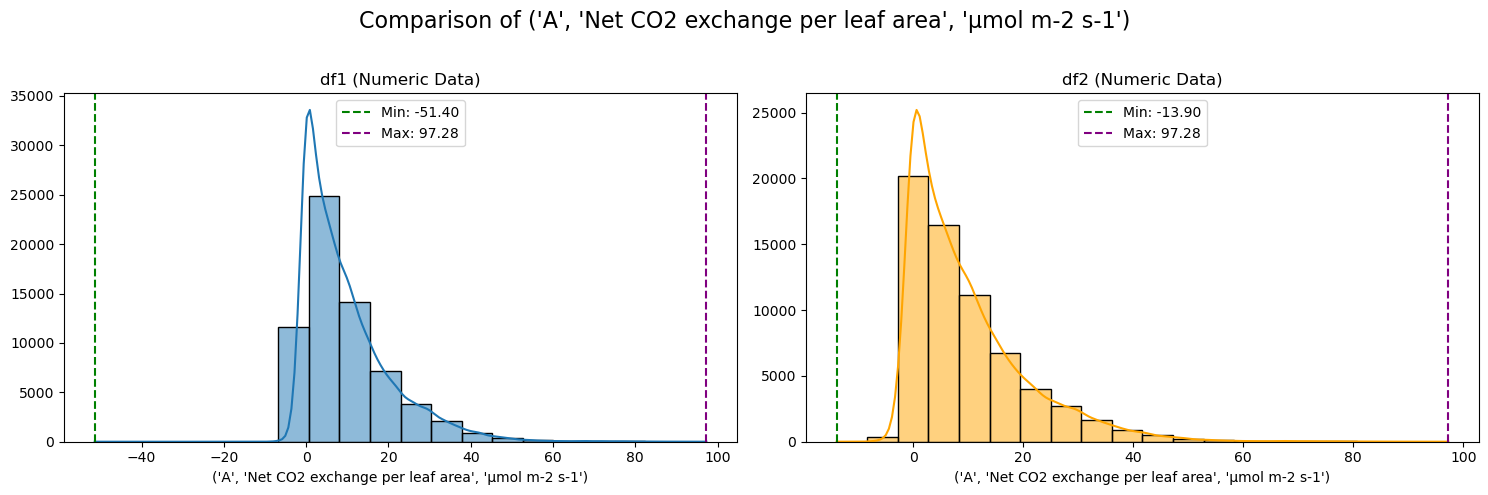

Visualizing ('Ci', 'Intercellular CO2 concentration in air', 'μmol mol-1')


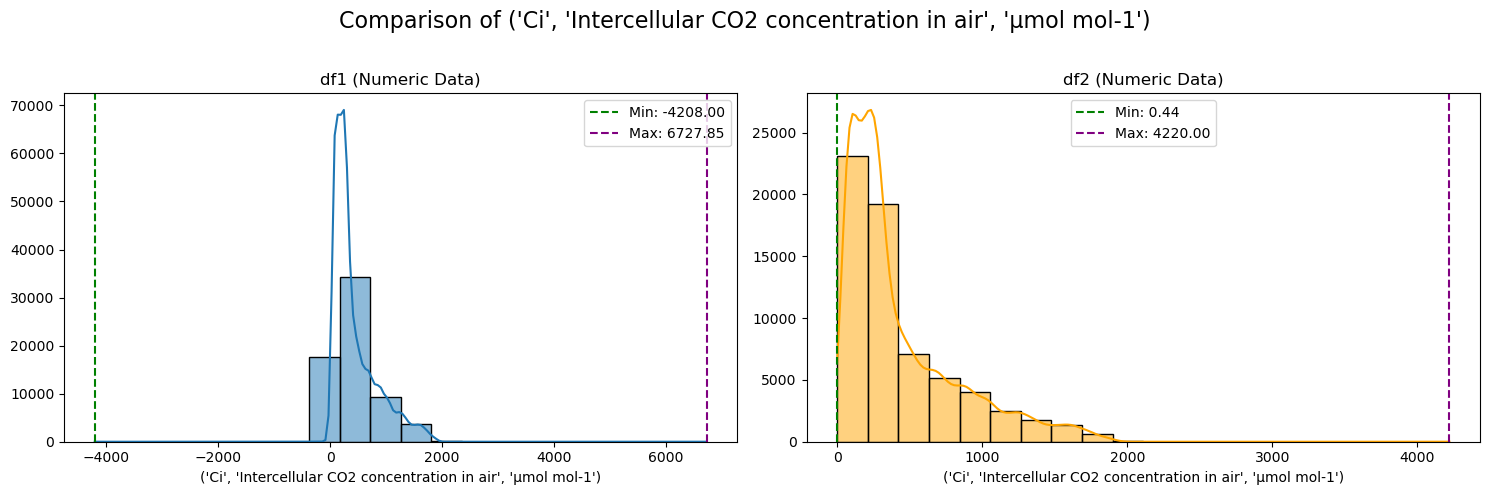

Visualizing ('CO2r', 'CO2 concentration in wet air entering chamber', 'μmol mol-1')


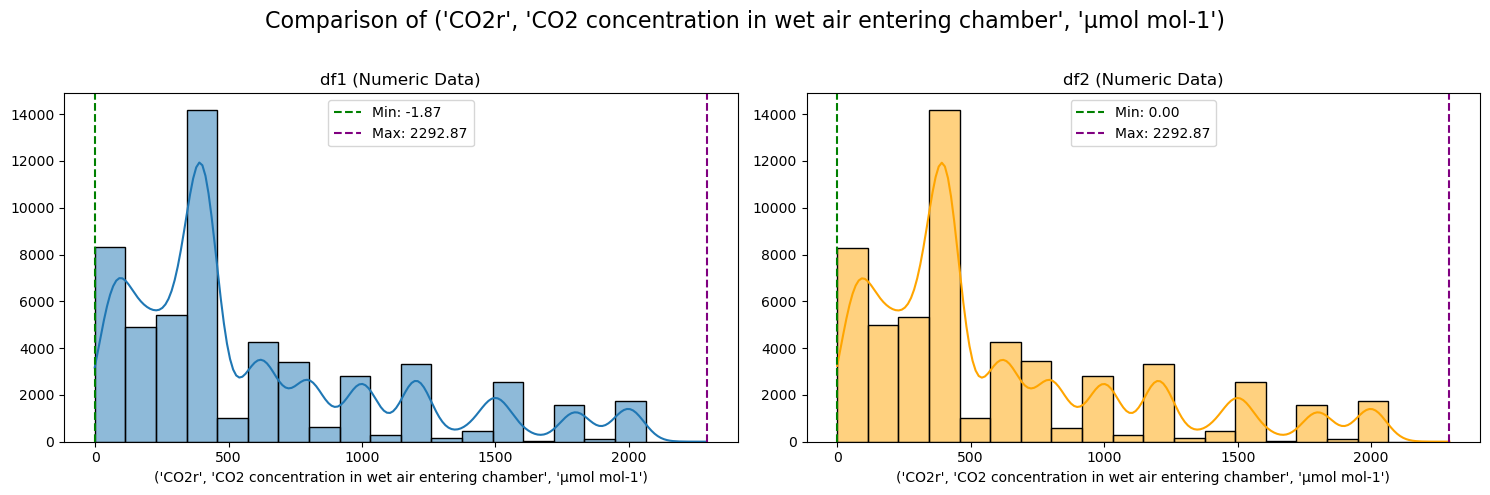

Visualizing ('CO2s', 'CO2 concentration in wet air inside chamber', 'μmol mol-1')


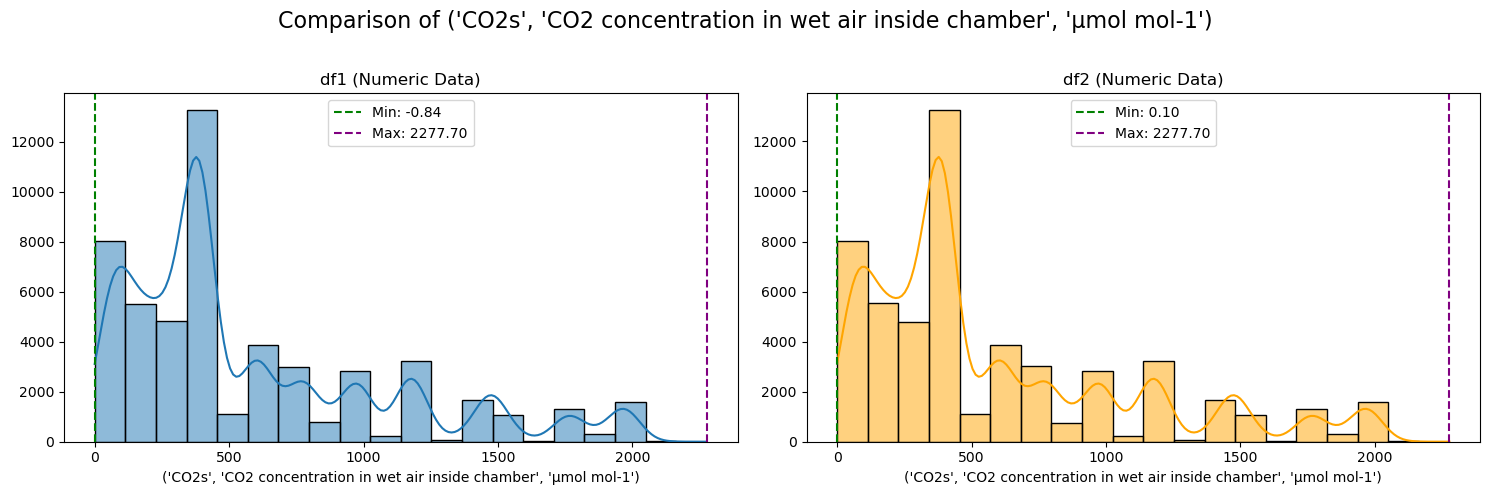

Visualizing ('gsw', 'Stomatal conductance to water vapor per leaf area', 'mmol m-2 s-1')


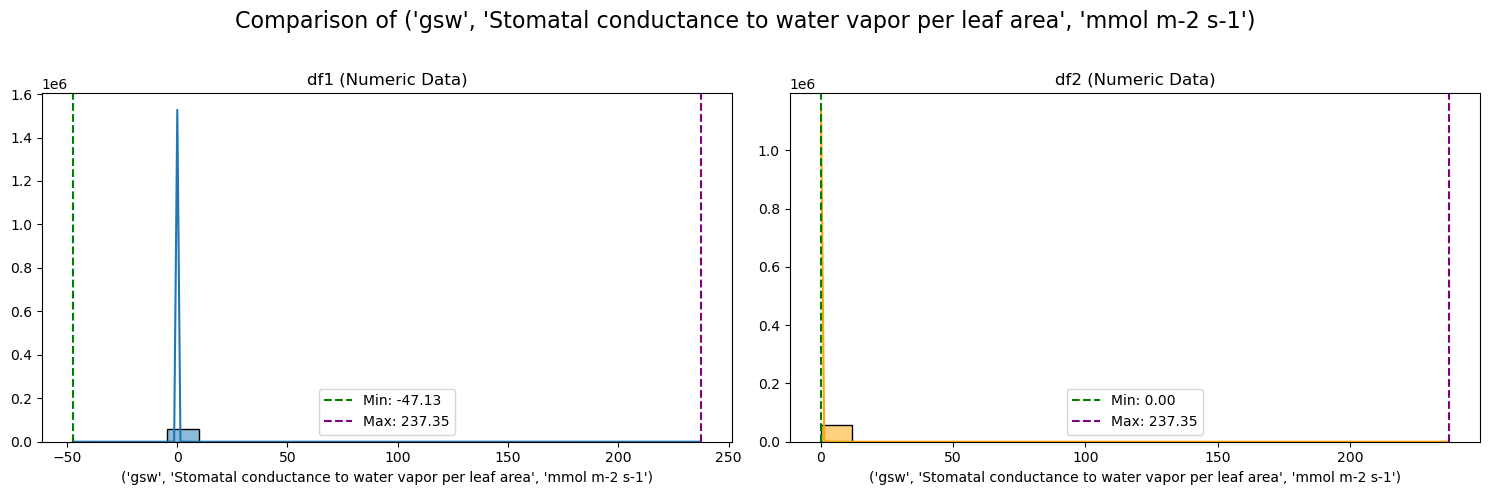

Visualizing ('VPDleaf', 'Leaf to air vapor pressure deficit', 'kPa')


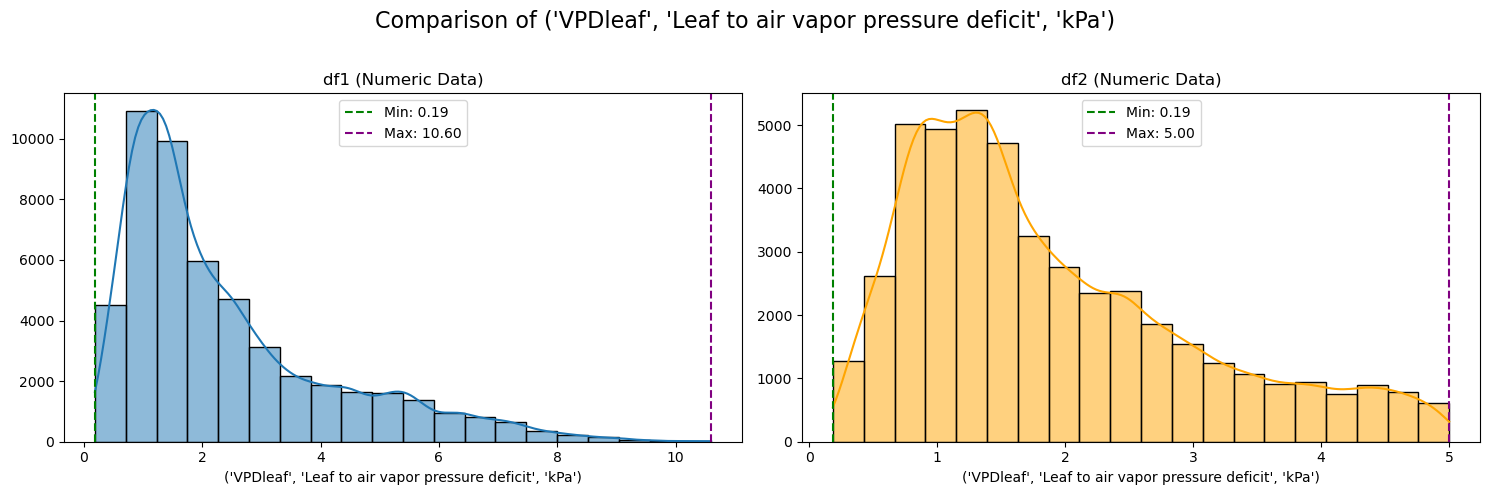

In [68]:
# Now plot the comparison
for oor_col in oor_cols:
    print(f'Visualizing {oor_col}')

    try:
        # Select columns using multi-level tuples
        selected_col_1 = merged_df_2[oor_col].squeeze()
        selected_col_2 = filtered_df[oor_col].squeeze()
        
        # Call the comparison plot function
        plot_comparison(selected_col_1, selected_col_2, oor_col)

    except Exception as e:
        print(f'Could not plot...', e)

In [69]:
# export
filtered_df.to_csv(f'../data/output/{filename}.csv', encoding='utf-8-sig')

In [70]:
# Create the profiling report
df = filtered_df.copy()
df.columns = df.columns.get_level_values(0)
profile = ProfileReport(df, title=f"{filename} Quality Controlled Profiling Report")

# Save the profile report as HTML
output_directory = f'../data/input/{filename}'
report_html_path = os.path.join(output_directory, f"{filename}_qc_report.html")
profile.to_file(report_html_path)
print(f"Profiling report saved as {report_html_path}")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Profiling report saved as ../data/input/kumarathunge_2019/kumarathunge_2019_qc_report.html
